In [89]:
# Imports
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from tqdm import trange
import pandas as pd
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.mlls import VariationalELBO
import random
import math
import seaborn as sns 
from sklearn.metrics import mean_squared_error


# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")


# set the seed for all random use
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

def setup(num_initial_points, acqFunc, noise):
    # Initial setup
    training_iterations = 20
    num_initial_points = num_initial_points
    num_new_samples_per_iteration = 1  # Change this to your desired number of new samples per iteration
    total_samples = 100
    acqFunc = acqFunc  # Change this to your desired acquisition function, UCB or EI
    noise = noise
    return training_iterations, num_initial_points, num_new_samples_per_iteration, total_samples, acqFunc, noise

CUDA device found, setting as device.


In [90]:
def generate_data(total_samples, noise):
    set_seeds(0)
    # Step 1: Define the mixture of Cauchy distributions
    def mixture_cauchy_function(x, x0s=[0], gammas=[1], weights=[1]):
        assert len(x0s) == len(gammas) == len(weights), "Length of parameters must match"
        mixture = np.zeros_like(x)
        for x0, gamma, weight in zip(x0s, gammas, weights):
            mixture += weight * (1 / (np.pi * gamma * (1 + ((x - x0) / gamma) ** 2)))
        return mixture / np.sum(weights)

    # Step 2: Sample points from the function
    np.random.seed(0)  # For reproducibility
    X = np.linspace(-10, 10, total_samples)
    x0s = [0, 0, 0]  # Location parameters
    gammas = [1, 3, 5]  # Scale parameters for heavier tails
    weights = [1, 1, 1]  # Equal weights for simplicity
    Y = mixture_cauchy_function(X, x0s, gammas, weights)

    # save the true function
    true_functionX = X/X.max()
    true_functionY = Y/Y.max()

    # Step 3: Add noise to the sampled points
    cauchy_noise = np.random.standard_cauchy(Y.shape) * noise
    Yc = Y + cauchy_noise
    Yc = Yc/Yc.max()
    X = X/X.max()

    train_x = torch.from_numpy(X.ravel()).to(dtype=torch.float64)
    train_y = torch.from_numpy(Yc.ravel()).to(dtype=torch.float64)

    N = len(train_x)
    n_top = int(math.ceil(N * 0.05))

    # find the top 5% of the samples
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nlargest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")

    return train_x, train_y, top_samples, true_functionX, true_functionY


In [91]:
class STP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(STP, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(0)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [92]:
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(ExactGP, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.dim()

        # use a scaled RBF kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [93]:
class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(0)))
        

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [94]:
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        # copy the tensor as to not modify the original 
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x

In [95]:
# Upper Confidence Bound
def UCB(mean, std, beta):
    return mean + beta * std


# Expected Improvement
def EI(mean, std, best_observed, minimize=False):
    if minimize:
        improvement = best_observed - mean
    else:
        improvement = mean - best_observed
    
    z = improvement / std
    normal = torch.distributions.Normal(0, 1)
    
    ei = improvement * normal.cdf(z) + std * normal.log_prob(z).exp()
    return ei

In [96]:

def TopSamplesAmnt(y, top_samples):
    return len([i for i in y if i in top_samples]) / len(top_samples)

In [97]:
def runMaxSTP(seed, num_initial_points, acqFunc):
    print("Maximizing with STP")
    set_seeds(seed)
    iterationSTP = [0]
    topSTP = [0]

    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesSTP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesSTP = non_top_5_indices[indicesSTP]

    # Select the corresponding points from train_x and train_y
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xSTP}")


    while topSTP[-1] < 100:
        iterationSTP.append(iterationSTP[-1] + 1)

        #def train_and_test_approximate_gp(objective_function_cls):
        model = STP(train_xSTP).to(dtype=torch.float64)
        #likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood = gpytorch.likelihoods.StudentTLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())

        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)


        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xSTP)
            loss = -objective_function(output, train_ySTP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with gpytorch.settings.num_likelihood_samples(512):
            pred = likelihood(model(train_x))

        samples = pred.sample()


        # use as inputs to UCB 
        meanSTP = samples.mean(dim=0)
        stdSTP = samples.std(dim=0)
        
        if acqFunc == "UCB":
            # Select new points using UCB
            ucb_values = UCB(meanSTP, stdSTP, 1.96)
            ucb_values[indicesSTP] = -float('inf')
            indicesSTP = torch.cat([indicesSTP, ucb_values.argmax().unsqueeze(0)])

        elif acqFunc == "EI":
            # Select new points using EI
            ei_values = EI(meanSTP, stdSTP, train_ySTP.max(), minimize=False)
            ei_values[indicesSTP] = -float('inf')
            indicesSTP = torch.cat([indicesSTP, ei_values.argmax().unsqueeze(0)])
        else:
            print("Please change the acquisition function to UCB or EI in the setup")
            raise ValueError("Invalid acquisition function specified")

        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]
        topSTP.append(TopSamplesAmnt(train_ySTP, top_samples)*100)

    print(f"Iterations: {iterationSTP[-1]}")
    return topSTP, iterationSTP, meanSTP, stdSTP, train_xSTP, train_ySTP

    


In [98]:
def runMaxEGP(seed, num_initial_points, acqFunc):
    print("Maximizing with EGP")
    set_seeds(seed)
    iterationEGP = [0]
    topEGP = [0]
    
    # find the top 5% of the samples
    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    top_5_percent_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these top-5% indices
    indicesEGP = torch.randperm(len(top_5_percent_indices))[:num_initial_points]
    indicesEGP = top_5_percent_indices[indicesEGP]
    initialPoints = indicesEGP

    # Select the corresponding points from train_x and train_y
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xEGP}")

    while topEGP[-1] < 100:
        iterationEGP.append(iterationEGP[-1] + 1)



        # optimize the model
        # use a half normal prior for the noise to find a Gaussian likelihood
        likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

        # using the found likelihood, create a GP model
        gp = ExactGP(train_xEGP, train_yEGP, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        # fit the model by maximizing the marginal log likelihood
        gp.train()
        likelihood.train()
        optimizer = torch.optim.Adam(gp.parameters(), lr=0.1)

        for _ in range(50):
            optimizer.zero_grad()
            output = gp(train_xEGP)
            loss = -mll(output, train_yEGP)
            loss.backward()
            optimizer.step()

        gp.eval()
        likelihood.eval()

        # predict from candidate pool
        with gpytorch.settings.num_likelihood_samples(512):
            pred = gp(train_x) # predict values for all candidates

        meanEGP = pred.mean
        stdEGP = pred.stddev

        if acqFunc == "UCB":
            # Select new points using UCB
            ucb_values = UCB(meanEGP, stdEGP, 1.96)
            ucb_values[indicesEGP] = -float('inf')
            indicesEGP = torch.cat([indicesEGP, ucb_values.argmax().unsqueeze(0)])

        elif acqFunc == "EI":
            # Select new points using EI
            ei_values = EI(meanEGP, stdEGP, train_yEGP.max(), minimize=False)
            ei_values[indicesEGP] = -float('inf')
            indicesEGP = torch.cat([indicesEGP, ei_values.argmax().unsqueeze(0)])
        else:
            print("Please change the acquisition function to UCB or EI in the setup")
            raise ValueError("Invalid acquisition function specified")

        # add the new point to the training data
        train_xEGP = train_x[indicesEGP]
        train_yEGP = train_y[indicesEGP]
        topEGP.append(TopSamplesAmnt(train_yEGP, top_samples)*100)
    print(f"Iterations: {iterationEGP[-1]}")
    return topEGP, iterationEGP, meanEGP, stdEGP, train_xEGP, train_yEGP

In [99]:
def runMaxVGP(seed, num_initial_points, acqFunc):
    print('Finding maximum with VGP')
    set_seeds(seed)
    iterationVGP = [0]
    topVGP = [0]

    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesVGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesVGP = non_top_5_indices[indicesVGP]

    
    initialPoints = train_x[indicesVGP]
    intialPointsy = train_y[indicesVGP]

    # Select the corresponding points from train_x and train_y
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xVGP}")
        
    while topVGP[-1] < 100:
        iterationVGP.append(iterationVGP[-1] + 1)


        #def train_and_test_approximate_gp(objective_function_cls):
        model = VariationalGP(train_xVGP).to(dtype=torch.float64)

        likelihood = GaussianLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xVGP)
            loss = -objective_function(output, train_yVGP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with gpytorch.settings.num_likelihood_samples(512):
            pred = likelihood(model(train_x))

        # get the mean and standard deviation of the samples
        meanVGP = pred.mean
        stdVGP = pred.stddev

        if acqFunc == "UCB":
            # Select new points using UCB
            ucb_values = UCB(meanVGP, stdVGP, 1.96)
            ucb_values[indicesVGP] = -float('inf')
            indicesVGP = torch.cat([indicesVGP, ucb_values.argmax().unsqueeze(0)])
        
        elif acqFunc == "EI":
            # Select new points using EI
            ei_values = EI(meanVGP, stdVGP, train_yVGP.max(), minimize=False)
            ei_values[indicesVGP] = -float('inf')
            indicesVGP = torch.cat([indicesVGP, ei_values.argmax().unsqueeze(0)])
        
        else:
            print("Please change the acquisition function to UCB or EI in the setup")
            raise ValueError("Invalid acquisition function specified")
        


        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xVGP = train_x[indicesVGP]
        train_yVGP = train_y[indicesVGP]
        topVGP.append(TopSamplesAmnt(train_yVGP, top_samples)*100)
    print(f"Iterations: {iterationVGP[-1]}")
    return topVGP, iterationVGP, meanVGP, stdVGP, initialPoints, train_xVGP, train_yVGP, intialPointsy


Number of of top 5% samples: 5
Top 5% samples: [1.0, 0.9252098566494826, 0.8535231620519833, 0.8206040020696823, 0.7822654709911511]


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with STP
Seed: 299
Initial points: tensor([ 0.7374, -0.3333, -0.1111], dtype=torch.float64)


  2%|▏         | 1/50 [00:14<11:31, 14.11s/it]

Iterations: 40
Maximizing with STP
Seed: 783
Initial points: tensor([0.3333, 0.5960, 0.4343], dtype=torch.float64)


  4%|▍         | 2/50 [00:42<17:53, 22.36s/it]

Iterations: 70
Maximizing with STP
Seed: 504
Initial points: tensor([ 0.7576, -0.5354, -0.4747], dtype=torch.float64)


  6%|▌         | 3/50 [01:02<16:42, 21.33s/it]

Iterations: 54
Maximizing with STP
Seed: 252
Initial points: tensor([ 0.2929, -0.6162,  0.5758], dtype=torch.float64)


  8%|▊         | 4/50 [01:31<18:45, 24.46s/it]

Iterations: 77
Maximizing with STP
Seed: 69
Initial points: tensor([ 0.2929,  0.4949, -0.2121], dtype=torch.float64)


 10%|█         | 5/50 [01:44<15:10, 20.22s/it]

Iterations: 37
Maximizing with STP
Seed: 268
Initial points: tensor([ 0.2121,  0.2929, -0.8182], dtype=torch.float64)


 12%|█▏        | 6/50 [01:52<11:51, 16.17s/it]

Iterations: 25
Maximizing with STP
Seed: 727
Initial points: tensor([ 0.1717, -0.4545,  0.8788], dtype=torch.float64)


 14%|█▍        | 7/50 [02:22<14:47, 20.64s/it]

Iterations: 80
Maximizing with STP
Seed: 387
Initial points: tensor([-0.4545, -0.6162,  0.7374], dtype=torch.float64)


 16%|█▌        | 8/50 [02:47<15:25, 22.04s/it]

Iterations: 68
Maximizing with STP
Seed: 500
Initial points: tensor([ 0.9394, -0.3535, -0.2323], dtype=torch.float64)


 18%|█▊        | 9/50 [03:10<15:12, 22.27s/it]

Iterations: 63
Maximizing with STP
Seed: 165
Initial points: tensor([0.8384, 0.1919, 1.0000], dtype=torch.float64)


 20%|██        | 10/50 [03:22<12:48, 19.20s/it]

Iterations: 36
Maximizing with STP
Seed: 395
Initial points: tensor([ 0.1111,  0.8384, -0.9596], dtype=torch.float64)


 22%|██▏       | 11/50 [03:26<09:28, 14.59s/it]

Iterations: 13
Maximizing with STP
Seed: 679
Initial points: tensor([-0.8182,  0.9798,  0.7980], dtype=torch.float64)


 24%|██▍       | 12/50 [03:47<10:25, 16.45s/it]

Iterations: 58
Maximizing with STP
Seed: 807
Initial points: tensor([ 0.8990, -0.7576, -0.3939], dtype=torch.float64)


 26%|██▌       | 13/50 [04:07<10:53, 17.67s/it]

Iterations: 57
Maximizing with STP
Seed: 104
Initial points: tensor([-0.2929, -0.7576, -0.7778], dtype=torch.float64)


 28%|██▊       | 14/50 [04:23<10:17, 17.16s/it]

Iterations: 46
Maximizing with STP
Seed: 618
Initial points: tensor([ 0.2323, -0.8586,  0.8586], dtype=torch.float64)


 30%|███       | 15/50 [04:47<11:07, 19.08s/it]

Iterations: 65
Maximizing with STP
Seed: 859
Initial points: tensor([-0.3131,  0.7576,  0.1515], dtype=torch.float64)


 32%|███▏      | 16/50 [05:08<11:10, 19.72s/it]

Iterations: 59
Maximizing with STP
Seed: 26
Initial points: tensor([-0.5152, -0.2929,  0.8182], dtype=torch.float64)


 34%|███▍      | 17/50 [05:23<09:59, 18.16s/it]

Iterations: 42
Maximizing with STP
Seed: 181
Initial points: tensor([-0.1717, -0.8788,  0.6566], dtype=torch.float64)


 36%|███▌      | 18/50 [05:51<11:14, 21.07s/it]

Iterations: 75
Maximizing with STP
Seed: 194
Initial points: tensor([ 0.4141, -0.6566, -0.6768], dtype=torch.float64)


 38%|███▊      | 19/50 [06:15<11:21, 21.99s/it]

Iterations: 66
Maximizing with STP
Seed: 601
Initial points: tensor([ 0.2727, -0.1717,  0.2929], dtype=torch.float64)


 40%|████      | 20/50 [06:39<11:20, 22.67s/it]

Iterations: 67
Maximizing with STP
Seed: 836
Initial points: tensor([ 0.2929,  0.5556, -0.7576], dtype=torch.float64)


 42%|████▏     | 21/50 [07:07<11:41, 24.19s/it]

Iterations: 76
Maximizing with STP
Seed: 632
Initial points: tensor([0.9798, 0.6566, 0.2727], dtype=torch.float64)


 44%|████▍     | 22/50 [07:36<11:58, 25.66s/it]

Iterations: 79
Maximizing with STP
Seed: 828
Initial points: tensor([-0.7576,  0.2323,  0.5556], dtype=torch.float64)


 46%|████▌     | 23/50 [07:49<09:49, 21.85s/it]

Iterations: 38
Maximizing with STP
Seed: 520
Initial points: tensor([ 0.7576, -0.6768,  0.8788], dtype=torch.float64)


 48%|████▊     | 24/50 [08:06<08:49, 20.37s/it]

Iterations: 48
Maximizing with STP
Seed: 5
Initial points: tensor([0.4141, 0.4343, 0.7980], dtype=torch.float64)


 50%|█████     | 25/50 [08:25<08:21, 20.04s/it]

Iterations: 55
Maximizing with STP
Seed: 850
Initial points: tensor([-0.4141, -0.6162, -0.6566], dtype=torch.float64)


 52%|█████▏    | 26/50 [08:39<07:20, 18.34s/it]

Iterations: 42
Maximizing with STP
Seed: 736
Initial points: tensor([ 0.1313,  0.7172, -0.1111], dtype=torch.float64)


 54%|█████▍    | 27/50 [08:50<06:09, 16.08s/it]

Iterations: 32
Maximizing with STP
Seed: 341
Initial points: tensor([-0.8586,  0.1313,  0.7374], dtype=torch.float64)


 56%|█████▌    | 28/50 [09:17<07:02, 19.19s/it]

Iterations: 70
Maximizing with STP
Seed: 212
Initial points: tensor([-0.0909, -0.0707,  0.3737], dtype=torch.float64)


 58%|█████▊    | 29/50 [09:44<07:34, 21.64s/it]

Iterations: 74
Maximizing with STP
Seed: 995
Initial points: tensor([-0.2929, -0.5152,  0.3737], dtype=torch.float64)


 60%|██████    | 30/50 [10:06<07:14, 21.72s/it]

Iterations: 61
Maximizing with STP
Seed: 380
Initial points: tensor([-0.2121,  0.7374,  0.8384], dtype=torch.float64)


 62%|██████▏   | 31/50 [10:34<07:31, 23.74s/it]

Iterations: 77
Maximizing with STP
Seed: 389
Initial points: tensor([ 0.2323, -0.3333, -0.9192], dtype=torch.float64)


 64%|██████▍   | 32/50 [10:48<06:14, 20.79s/it]

Iterations: 40
Maximizing with STP
Seed: 205
Initial points: tensor([-0.4545,  0.3939,  0.1919], dtype=torch.float64)


 66%|██████▌   | 33/50 [11:11<06:02, 21.32s/it]

Iterations: 63
Maximizing with STP
Seed: 129
Initial points: tensor([ 0.6566, -0.5960,  0.9394], dtype=torch.float64)


 68%|██████▊   | 34/50 [11:32<05:41, 21.35s/it]

Iterations: 60
Maximizing with STP
Seed: 784
Initial points: tensor([-0.8586,  0.5758, -0.7980], dtype=torch.float64)


 70%|███████   | 35/50 [11:55<05:28, 21.89s/it]

Iterations: 64
Maximizing with STP
Seed: 819
Initial points: tensor([0.3333, 0.0303, 0.2323], dtype=torch.float64)


 72%|███████▏  | 36/50 [12:19<05:14, 22.45s/it]

Iterations: 65
Maximizing with STP
Seed: 150
Initial points: tensor([-0.9798,  0.2727,  0.9798], dtype=torch.float64)


 74%|███████▍  | 37/50 [12:45<05:06, 23.57s/it]

Iterations: 71
Maximizing with STP
Seed: 92
Initial points: tensor([ 0.2929,  0.7778, -0.8990], dtype=torch.float64)


 76%|███████▌  | 38/50 [13:05<04:30, 22.58s/it]

Iterations: 57
Maximizing with STP
Seed: 889
Initial points: tensor([ 0.9596,  0.7576, -0.5152], dtype=torch.float64)


 78%|███████▊  | 39/50 [13:33<04:25, 24.18s/it]

Iterations: 76
Maximizing with STP
Seed: 85
Initial points: tensor([ 0.8384, -0.1717,  0.1919], dtype=torch.float64)


 80%|████████  | 40/50 [13:49<03:35, 21.55s/it]

Iterations: 44
Maximizing with STP
Seed: 993
Initial points: tensor([ 0.7172, -0.7172, -0.2323], dtype=torch.float64)


 82%|████████▏ | 41/50 [14:01<02:47, 18.63s/it]

Iterations: 34
Maximizing with STP
Seed: 432
Initial points: tensor([ 0.5354, -0.7374, -0.2525], dtype=torch.float64)


 84%|████████▍ | 42/50 [14:29<02:52, 21.55s/it]

Iterations: 77
Maximizing with STP
Seed: 366
Initial points: tensor([ 0.4545, -0.7172, -0.3333], dtype=torch.float64)


 86%|████████▌ | 43/50 [14:59<02:49, 24.20s/it]

Iterations: 82
Maximizing with STP
Seed: 289
Initial points: tensor([ 0.4343,  0.1515, -0.6768], dtype=torch.float64)


 88%|████████▊ | 44/50 [15:07<01:55, 19.23s/it]

Iterations: 23
Maximizing with STP
Seed: 982
Initial points: tensor([-0.9394,  0.4545,  0.7172], dtype=torch.float64)


 90%|█████████ | 45/50 [15:13<01:16, 15.35s/it]

Iterations: 19
Maximizing with STP
Seed: 455
Initial points: tensor([-0.5556,  0.3131,  0.8788], dtype=torch.float64)


 92%|█████████▏| 46/50 [15:38<01:12, 18.09s/it]

Iterations: 68
Maximizing with STP
Seed: 534
Initial points: tensor([-0.6566,  0.2323, -0.7778], dtype=torch.float64)


 94%|█████████▍| 47/50 [16:04<01:01, 20.55s/it]

Iterations: 72
Maximizing with STP
Seed: 362
Initial points: tensor([ 0.8990, -0.1313,  0.8788], dtype=torch.float64)


 96%|█████████▌| 48/50 [16:30<00:44, 22.02s/it]

Iterations: 71
Maximizing with STP
Seed: 443
Initial points: tensor([1.0000, 0.6566, 0.0909], dtype=torch.float64)


 98%|█████████▊| 49/50 [16:55<00:22, 22.97s/it]

Iterations: 70
Maximizing with STP
Seed: 892
Initial points: tensor([-0.5960,  0.3333,  0.3131], dtype=torch.float64)


100%|██████████| 50/50 [17:13<00:00, 20.66s/it]


Iterations: 52


  0%|          | 0/50 [00:00<?, ?it/s]

Finding maximum with VGP
Seed: 299
Initial points: tensor([ 0.7374, -0.3333, -0.1111], dtype=torch.float64)


  2%|▏         | 1/50 [00:10<08:25, 10.31s/it]

Iterations: 51
Finding maximum with VGP
Seed: 783
Initial points: tensor([0.3333, 0.5960, 0.4343], dtype=torch.float64)


  4%|▍         | 2/50 [00:17<06:42,  8.39s/it]

Iterations: 37
Finding maximum with VGP
Seed: 504
Initial points: tensor([ 0.7576, -0.5354, -0.4747], dtype=torch.float64)


  6%|▌         | 3/50 [00:35<09:55, 12.67s/it]

Iterations: 86
Finding maximum with VGP
Seed: 252
Initial points: tensor([ 0.2929, -0.6162,  0.5758], dtype=torch.float64)


  8%|▊         | 4/50 [00:43<08:24, 10.96s/it]

Iterations: 43
Finding maximum with VGP
Seed: 69
Initial points: tensor([ 0.2929,  0.4949, -0.2121], dtype=torch.float64)


 10%|█         | 5/50 [01:01<10:01, 13.37s/it]

Iterations: 85
Finding maximum with VGP
Seed: 268
Initial points: tensor([ 0.2121,  0.2929, -0.8182], dtype=torch.float64)


 12%|█▏        | 6/50 [01:18<10:53, 14.86s/it]

Iterations: 85
Finding maximum with VGP
Seed: 727
Initial points: tensor([ 0.1717, -0.4545,  0.8788], dtype=torch.float64)


 14%|█▍        | 7/50 [01:35<10:59, 15.34s/it]

Iterations: 80
Finding maximum with VGP
Seed: 387
Initial points: tensor([-0.4545, -0.6162,  0.7374], dtype=torch.float64)


 16%|█▌        | 8/50 [01:45<09:42, 13.86s/it]

Iterations: 55
Finding maximum with VGP
Seed: 500
Initial points: tensor([ 0.9394, -0.3535, -0.2323], dtype=torch.float64)


 18%|█▊        | 9/50 [01:59<09:31, 13.94s/it]

Iterations: 71
Finding maximum with VGP
Seed: 165
Initial points: tensor([0.8384, 0.1919, 1.0000], dtype=torch.float64)


 20%|██        | 10/50 [02:03<07:10, 10.77s/it]

Iterations: 20
Finding maximum with VGP
Seed: 395
Initial points: tensor([ 0.1111,  0.8384, -0.9596], dtype=torch.float64)


 22%|██▏       | 11/50 [02:22<08:37, 13.28s/it]

Iterations: 91
Finding maximum with VGP
Seed: 679
Initial points: tensor([-0.8182,  0.9798,  0.7980], dtype=torch.float64)


 24%|██▍       | 12/50 [02:40<09:12, 14.55s/it]

Iterations: 84
Finding maximum with VGP
Seed: 807
Initial points: tensor([ 0.8990, -0.7576, -0.3939], dtype=torch.float64)


 26%|██▌       | 13/50 [02:52<08:30, 13.81s/it]

Iterations: 62
Finding maximum with VGP
Seed: 104
Initial points: tensor([-0.2929, -0.7576, -0.7778], dtype=torch.float64)


 28%|██▊       | 14/50 [03:01<07:33, 12.60s/it]

Iterations: 51
Finding maximum with VGP
Seed: 618
Initial points: tensor([ 0.2323, -0.8586,  0.8586], dtype=torch.float64)


 30%|███       | 15/50 [03:07<06:09, 10.55s/it]

Iterations: 31
Finding maximum with VGP
Seed: 859
Initial points: tensor([-0.3131,  0.7576,  0.1515], dtype=torch.float64)


 32%|███▏      | 16/50 [03:19<06:10, 10.90s/it]

Iterations: 60
Finding maximum with VGP
Seed: 26
Initial points: tensor([-0.5152, -0.2929,  0.8182], dtype=torch.float64)


 34%|███▍      | 17/50 [03:33<06:31, 11.86s/it]

Iterations: 70
Finding maximum with VGP
Seed: 181
Initial points: tensor([-0.1717, -0.8788,  0.6566], dtype=torch.float64)


 36%|███▌      | 18/50 [03:42<05:48, 10.89s/it]

Iterations: 45
Finding maximum with VGP
Seed: 194
Initial points: tensor([ 0.4141, -0.6566, -0.6768], dtype=torch.float64)


 38%|███▊      | 19/50 [03:49<05:00,  9.68s/it]

Iterations: 36
Finding maximum with VGP
Seed: 601
Initial points: tensor([ 0.2727, -0.1717,  0.2929], dtype=torch.float64)


 40%|████      | 20/50 [04:07<06:04, 12.17s/it]

Iterations: 85
Finding maximum with VGP
Seed: 836
Initial points: tensor([ 0.2929,  0.5556, -0.7576], dtype=torch.float64)


 42%|████▏     | 21/50 [04:12<04:54, 10.15s/it]

Iterations: 29
Finding maximum with VGP
Seed: 632
Initial points: tensor([0.9798, 0.6566, 0.2727], dtype=torch.float64)


 44%|████▍     | 22/50 [04:19<04:14,  9.10s/it]

Iterations: 35
Finding maximum with VGP
Seed: 828
Initial points: tensor([-0.7576,  0.2323,  0.5556], dtype=torch.float64)


 46%|████▌     | 23/50 [04:30<04:24,  9.79s/it]

Iterations: 58
Finding maximum with VGP
Seed: 520
Initial points: tensor([ 0.7576, -0.6768,  0.8788], dtype=torch.float64)


 48%|████▊     | 24/50 [04:46<05:02, 11.63s/it]

Iterations: 77
Finding maximum with VGP
Seed: 5
Initial points: tensor([0.4141, 0.4343, 0.7980], dtype=torch.float64)


 50%|█████     | 25/50 [05:03<05:32, 13.29s/it]

Iterations: 77
Finding maximum with VGP
Seed: 850
Initial points: tensor([-0.4141, -0.6162, -0.6566], dtype=torch.float64)


 52%|█████▏    | 26/50 [05:20<05:48, 14.50s/it]

Iterations: 81
Finding maximum with VGP
Seed: 736
Initial points: tensor([ 0.1313,  0.7172, -0.1111], dtype=torch.float64)


 54%|█████▍    | 27/50 [05:29<04:55, 12.84s/it]

Iterations: 45
Finding maximum with VGP
Seed: 341
Initial points: tensor([-0.8586,  0.1313,  0.7374], dtype=torch.float64)


 56%|█████▌    | 28/50 [05:44<04:56, 13.48s/it]

Iterations: 69
Finding maximum with VGP
Seed: 212
Initial points: tensor([-0.0909, -0.0707,  0.3737], dtype=torch.float64)


 58%|█████▊    | 29/50 [06:02<05:06, 14.59s/it]

Iterations: 79
Finding maximum with VGP
Seed: 995
Initial points: tensor([-0.2929, -0.5152,  0.3737], dtype=torch.float64)


 60%|██████    | 30/50 [06:22<05:25, 16.27s/it]

Iterations: 90
Finding maximum with VGP
Seed: 380
Initial points: tensor([-0.2121,  0.7374,  0.8384], dtype=torch.float64)


 62%|██████▏   | 31/50 [06:37<05:02, 15.92s/it]

Iterations: 71
Finding maximum with VGP
Seed: 389
Initial points: tensor([ 0.2323, -0.3333, -0.9192], dtype=torch.float64)


 64%|██████▍   | 32/50 [06:56<05:03, 16.85s/it]

Iterations: 86
Finding maximum with VGP
Seed: 205
Initial points: tensor([-0.4545,  0.3939,  0.1919], dtype=torch.float64)


 66%|██████▌   | 33/50 [07:14<04:52, 17.21s/it]

Iterations: 85
Finding maximum with VGP
Seed: 129
Initial points: tensor([ 0.6566, -0.5960,  0.9394], dtype=torch.float64)


 68%|██████▊   | 34/50 [07:30<04:28, 16.78s/it]

Iterations: 76
Finding maximum with VGP
Seed: 784
Initial points: tensor([-0.8586,  0.5758, -0.7980], dtype=torch.float64)


 70%|███████   | 35/50 [07:48<04:19, 17.29s/it]

Iterations: 88
Finding maximum with VGP
Seed: 819
Initial points: tensor([0.3333, 0.0303, 0.2323], dtype=torch.float64)


 72%|███████▏  | 36/50 [08:05<04:00, 17.16s/it]

Iterations: 76
Finding maximum with VGP
Seed: 150
Initial points: tensor([-0.9798,  0.2727,  0.9798], dtype=torch.float64)


 74%|███████▍  | 37/50 [08:22<03:43, 17.21s/it]

Iterations: 79
Finding maximum with VGP
Seed: 92
Initial points: tensor([ 0.2929,  0.7778, -0.8990], dtype=torch.float64)


 76%|███████▌  | 38/50 [08:42<03:36, 18.04s/it]

Iterations: 90
Finding maximum with VGP
Seed: 889
Initial points: tensor([ 0.9596,  0.7576, -0.5152], dtype=torch.float64)


 78%|███████▊  | 39/50 [08:55<03:01, 16.54s/it]

Iterations: 62
Finding maximum with VGP
Seed: 85
Initial points: tensor([ 0.8384, -0.1717,  0.1919], dtype=torch.float64)


 80%|████████  | 40/50 [09:04<02:22, 14.22s/it]

Iterations: 44
Finding maximum with VGP
Seed: 993
Initial points: tensor([ 0.7172, -0.7172, -0.2323], dtype=torch.float64)


 82%|████████▏ | 41/50 [09:13<01:54, 12.71s/it]

Iterations: 47
Finding maximum with VGP
Seed: 432
Initial points: tensor([ 0.5354, -0.7374, -0.2525], dtype=torch.float64)


 84%|████████▍ | 42/50 [09:19<01:23, 10.49s/it]

Iterations: 28
Finding maximum with VGP
Seed: 366
Initial points: tensor([ 0.4545, -0.7172, -0.3333], dtype=torch.float64)


 86%|████████▌ | 43/50 [09:27<01:07,  9.71s/it]

Iterations: 41
Finding maximum with VGP
Seed: 289
Initial points: tensor([ 0.4343,  0.1515, -0.6768], dtype=torch.float64)


 88%|████████▊ | 44/50 [09:33<00:51,  8.66s/it]

Iterations: 32
Finding maximum with VGP
Seed: 982
Initial points: tensor([-0.9394,  0.4545,  0.7172], dtype=torch.float64)


 90%|█████████ | 45/50 [09:37<00:36,  7.38s/it]

Iterations: 23
Finding maximum with VGP
Seed: 455
Initial points: tensor([-0.5556,  0.3131,  0.8788], dtype=torch.float64)


 92%|█████████▏| 46/50 [09:53<00:39,  9.99s/it]

Iterations: 76
Finding maximum with VGP
Seed: 534
Initial points: tensor([-0.6566,  0.2323, -0.7778], dtype=torch.float64)


 94%|█████████▍| 47/50 [10:12<00:37, 12.56s/it]

Iterations: 85
Finding maximum with VGP
Seed: 362
Initial points: tensor([ 0.8990, -0.1313,  0.8788], dtype=torch.float64)


 96%|█████████▌| 48/50 [10:29<00:28, 14.02s/it]

Iterations: 80
Finding maximum with VGP
Seed: 443
Initial points: tensor([1.0000, 0.6566, 0.0909], dtype=torch.float64)


 98%|█████████▊| 49/50 [10:40<00:13, 13.11s/it]

Iterations: 50
Finding maximum with VGP
Seed: 892
Initial points: tensor([-0.5960,  0.3333,  0.3131], dtype=torch.float64)


100%|██████████| 50/50 [11:00<00:00, 13.21s/it]


Iterations: 86


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with EGP
Seed: 299
Initial points: tensor([ 0.7374, -0.3333, -0.1111], dtype=torch.float64)


  2%|▏         | 1/50 [00:07<06:14,  7.64s/it]

Iterations: 87
Maximizing with EGP
Seed: 783
Initial points: tensor([0.3333, 0.5960, 0.4343], dtype=torch.float64)


  4%|▍         | 2/50 [00:12<04:55,  6.17s/it]

Iterations: 60
Maximizing with EGP
Seed: 504
Initial points: tensor([ 0.7576, -0.5354, -0.4747], dtype=torch.float64)


  6%|▌         | 3/50 [00:19<05:07,  6.54s/it]

Iterations: 80
Maximizing with EGP
Seed: 252
Initial points: tensor([ 0.2929, -0.6162,  0.5758], dtype=torch.float64)


  8%|▊         | 4/50 [00:26<04:55,  6.43s/it]

Iterations: 73
Maximizing with EGP
Seed: 69
Initial points: tensor([ 0.2929,  0.4949, -0.2121], dtype=torch.float64)


 10%|█         | 5/50 [00:32<04:56,  6.60s/it]

Iterations: 77
Maximizing with EGP
Seed: 268
Initial points: tensor([ 0.2121,  0.2929, -0.8182], dtype=torch.float64)


 12%|█▏        | 6/50 [00:40<05:08,  7.02s/it]

Iterations: 86
Maximizing with EGP
Seed: 727
Initial points: tensor([ 0.1717, -0.4545,  0.8788], dtype=torch.float64)


 14%|█▍        | 7/50 [00:42<03:53,  5.44s/it]

Iterations: 25
Maximizing with EGP
Seed: 387
Initial points: tensor([-0.4545, -0.6162,  0.7374], dtype=torch.float64)


 16%|█▌        | 8/50 [00:46<03:19,  4.75s/it]

Iterations: 37
Maximizing with EGP
Seed: 500
Initial points: tensor([ 0.9394, -0.3535, -0.2323], dtype=torch.float64)


 18%|█▊        | 9/50 [00:52<03:33,  5.20s/it]

Iterations: 69
Maximizing with EGP
Seed: 165
Initial points: tensor([0.8384, 0.1919, 1.0000], dtype=torch.float64)


 20%|██        | 10/50 [00:59<03:48,  5.71s/it]

Iterations: 78
Maximizing with EGP
Seed: 395
Initial points: tensor([ 0.1111,  0.8384, -0.9596], dtype=torch.float64)


 22%|██▏       | 11/50 [01:04<03:40,  5.66s/it]

Iterations: 67
Maximizing with EGP
Seed: 679
Initial points: tensor([-0.8182,  0.9798,  0.7980], dtype=torch.float64)


 24%|██▍       | 12/50 [01:07<03:02,  4.79s/it]

Iterations: 34
Maximizing with EGP
Seed: 807
Initial points: tensor([ 0.8990, -0.7576, -0.3939], dtype=torch.float64)


 26%|██▌       | 13/50 [01:12<02:59,  4.86s/it]

Iterations: 58
Maximizing with EGP
Seed: 104
Initial points: tensor([-0.2929, -0.7576, -0.7778], dtype=torch.float64)


 28%|██▊       | 14/50 [01:15<02:30,  4.17s/it]

Iterations: 30
Maximizing with EGP
Seed: 618
Initial points: tensor([ 0.2323, -0.8586,  0.8586], dtype=torch.float64)


 30%|███       | 15/50 [01:22<02:56,  5.03s/it]

Iterations: 79
Maximizing with EGP
Seed: 859
Initial points: tensor([-0.3131,  0.7576,  0.1515], dtype=torch.float64)


 32%|███▏      | 16/50 [01:26<02:44,  4.84s/it]

Iterations: 53
Maximizing with EGP
Seed: 26
Initial points: tensor([-0.5152, -0.2929,  0.8182], dtype=torch.float64)


 34%|███▍      | 17/50 [01:34<03:06,  5.66s/it]

Iterations: 86
Maximizing with EGP
Seed: 181
Initial points: tensor([-0.1717, -0.8788,  0.6566], dtype=torch.float64)


 36%|███▌      | 18/50 [01:41<03:14,  6.09s/it]

Iterations: 79
Maximizing with EGP
Seed: 194
Initial points: tensor([ 0.4141, -0.6566, -0.6768], dtype=torch.float64)


 38%|███▊      | 19/50 [01:48<03:20,  6.48s/it]

Iterations: 86
Maximizing with EGP
Seed: 601
Initial points: tensor([ 0.2727, -0.1717,  0.2929], dtype=torch.float64)


 40%|████      | 20/50 [01:54<03:08,  6.28s/it]

Iterations: 68
Maximizing with EGP
Seed: 836
Initial points: tensor([ 0.2929,  0.5556, -0.7576], dtype=torch.float64)


 42%|████▏     | 21/50 [02:02<03:17,  6.81s/it]

Iterations: 91
Maximizing with EGP
Seed: 632
Initial points: tensor([0.9798, 0.6566, 0.2727], dtype=torch.float64)


 44%|████▍     | 22/50 [02:10<03:16,  7.03s/it]

Iterations: 87
Maximizing with EGP
Seed: 828
Initial points: tensor([-0.7576,  0.2323,  0.5556], dtype=torch.float64)


 46%|████▌     | 23/50 [02:17<03:11,  7.08s/it]

Iterations: 84
Maximizing with EGP
Seed: 520
Initial points: tensor([ 0.7576, -0.6768,  0.8788], dtype=torch.float64)


 48%|████▊     | 24/50 [02:24<03:07,  7.22s/it]

Iterations: 84
Maximizing with EGP
Seed: 5
Initial points: tensor([0.4141, 0.4343, 0.7980], dtype=torch.float64)


 50%|█████     | 25/50 [02:32<03:03,  7.34s/it]

Iterations: 86
Maximizing with EGP
Seed: 850
Initial points: tensor([-0.4141, -0.6162, -0.6566], dtype=torch.float64)


 52%|█████▏    | 26/50 [02:37<02:37,  6.55s/it]

Iterations: 55
Maximizing with EGP
Seed: 736
Initial points: tensor([ 0.1313,  0.7172, -0.1111], dtype=torch.float64)


 54%|█████▍    | 27/50 [02:41<02:13,  5.81s/it]

Iterations: 49
Maximizing with EGP
Seed: 341
Initial points: tensor([-0.8586,  0.1313,  0.7374], dtype=torch.float64)


 56%|█████▌    | 28/50 [02:48<02:19,  6.36s/it]

Iterations: 88
Maximizing with EGP
Seed: 212
Initial points: tensor([-0.0909, -0.0707,  0.3737], dtype=torch.float64)


 58%|█████▊    | 29/50 [02:56<02:21,  6.76s/it]

Iterations: 86
Maximizing with EGP
Seed: 995
Initial points: tensor([-0.2929, -0.5152,  0.3737], dtype=torch.float64)


 60%|██████    | 30/50 [03:02<02:09,  6.50s/it]

Iterations: 67
Maximizing with EGP
Seed: 380
Initial points: tensor([-0.2121,  0.7374,  0.8384], dtype=torch.float64)


 62%|██████▏   | 31/50 [03:07<01:57,  6.16s/it]

Iterations: 61
Maximizing with EGP
Seed: 389
Initial points: tensor([ 0.2323, -0.3333, -0.9192], dtype=torch.float64)


 64%|██████▍   | 32/50 [03:13<01:50,  6.14s/it]

Iterations: 71
Maximizing with EGP
Seed: 205
Initial points: tensor([-0.4545,  0.3939,  0.1919], dtype=torch.float64)


 66%|██████▌   | 33/50 [03:20<01:44,  6.16s/it]

Iterations: 73
Maximizing with EGP
Seed: 129
Initial points: tensor([ 0.6566, -0.5960,  0.9394], dtype=torch.float64)


 68%|██████▊   | 34/50 [03:26<01:39,  6.24s/it]

Iterations: 71
Maximizing with EGP
Seed: 784
Initial points: tensor([-0.8586,  0.5758, -0.7980], dtype=torch.float64)


 70%|███████   | 35/50 [03:31<01:27,  5.86s/it]

Iterations: 57
Maximizing with EGP
Seed: 819
Initial points: tensor([0.3333, 0.0303, 0.2323], dtype=torch.float64)


 72%|███████▏  | 36/50 [03:33<01:04,  4.61s/it]

Iterations: 19
Maximizing with EGP
Seed: 150
Initial points: tensor([-0.9798,  0.2727,  0.9798], dtype=torch.float64)


 74%|███████▍  | 37/50 [03:37<01:00,  4.65s/it]

Iterations: 57
Maximizing with EGP
Seed: 92
Initial points: tensor([ 0.2929,  0.7778, -0.8990], dtype=torch.float64)


 76%|███████▌  | 38/50 [03:43<00:59,  4.94s/it]

Iterations: 64
Maximizing with EGP
Seed: 889
Initial points: tensor([ 0.9596,  0.7576, -0.5152], dtype=torch.float64)


 78%|███████▊  | 39/50 [03:46<00:48,  4.40s/it]

Iterations: 36
Maximizing with EGP
Seed: 85
Initial points: tensor([ 0.8384, -0.1717,  0.1919], dtype=torch.float64)


 80%|████████  | 40/50 [03:51<00:46,  4.63s/it]

Iterations: 59
Maximizing with EGP
Seed: 993
Initial points: tensor([ 0.7172, -0.7172, -0.2323], dtype=torch.float64)


 82%|████████▏ | 41/50 [03:59<00:50,  5.56s/it]

Iterations: 90
Maximizing with EGP
Seed: 432
Initial points: tensor([ 0.5354, -0.7374, -0.2525], dtype=torch.float64)


 84%|████████▍ | 42/50 [04:05<00:44,  5.59s/it]

Iterations: 66
Maximizing with EGP
Seed: 366
Initial points: tensor([ 0.4545, -0.7172, -0.3333], dtype=torch.float64)


 86%|████████▌ | 43/50 [04:11<00:41,  5.92s/it]

Iterations: 78
Maximizing with EGP
Seed: 289
Initial points: tensor([ 0.4343,  0.1515, -0.6768], dtype=torch.float64)


 88%|████████▊ | 44/50 [04:18<00:37,  6.18s/it]

Iterations: 79
Maximizing with EGP
Seed: 982
Initial points: tensor([-0.9394,  0.4545,  0.7172], dtype=torch.float64)


 90%|█████████ | 45/50 [04:25<00:31,  6.40s/it]

Iterations: 80
Maximizing with EGP
Seed: 455
Initial points: tensor([-0.5556,  0.3131,  0.8788], dtype=torch.float64)


 92%|█████████▏| 46/50 [04:33<00:27,  6.77s/it]

Iterations: 83
Maximizing with EGP
Seed: 534
Initial points: tensor([-0.6566,  0.2323, -0.7778], dtype=torch.float64)


 94%|█████████▍| 47/50 [04:39<00:20,  6.76s/it]

Iterations: 75
Maximizing with EGP
Seed: 362
Initial points: tensor([ 0.8990, -0.1313,  0.8788], dtype=torch.float64)


 96%|█████████▌| 48/50 [04:47<00:14,  7.07s/it]

Iterations: 88
Maximizing with EGP
Seed: 443
Initial points: tensor([1.0000, 0.6566, 0.0909], dtype=torch.float64)


 98%|█████████▊| 49/50 [04:55<00:07,  7.13s/it]

Iterations: 85
Maximizing with EGP
Seed: 892
Initial points: tensor([-0.5960,  0.3333,  0.3131], dtype=torch.float64)


100%|██████████| 50/50 [05:01<00:00,  6.02s/it]

Iterations: 72


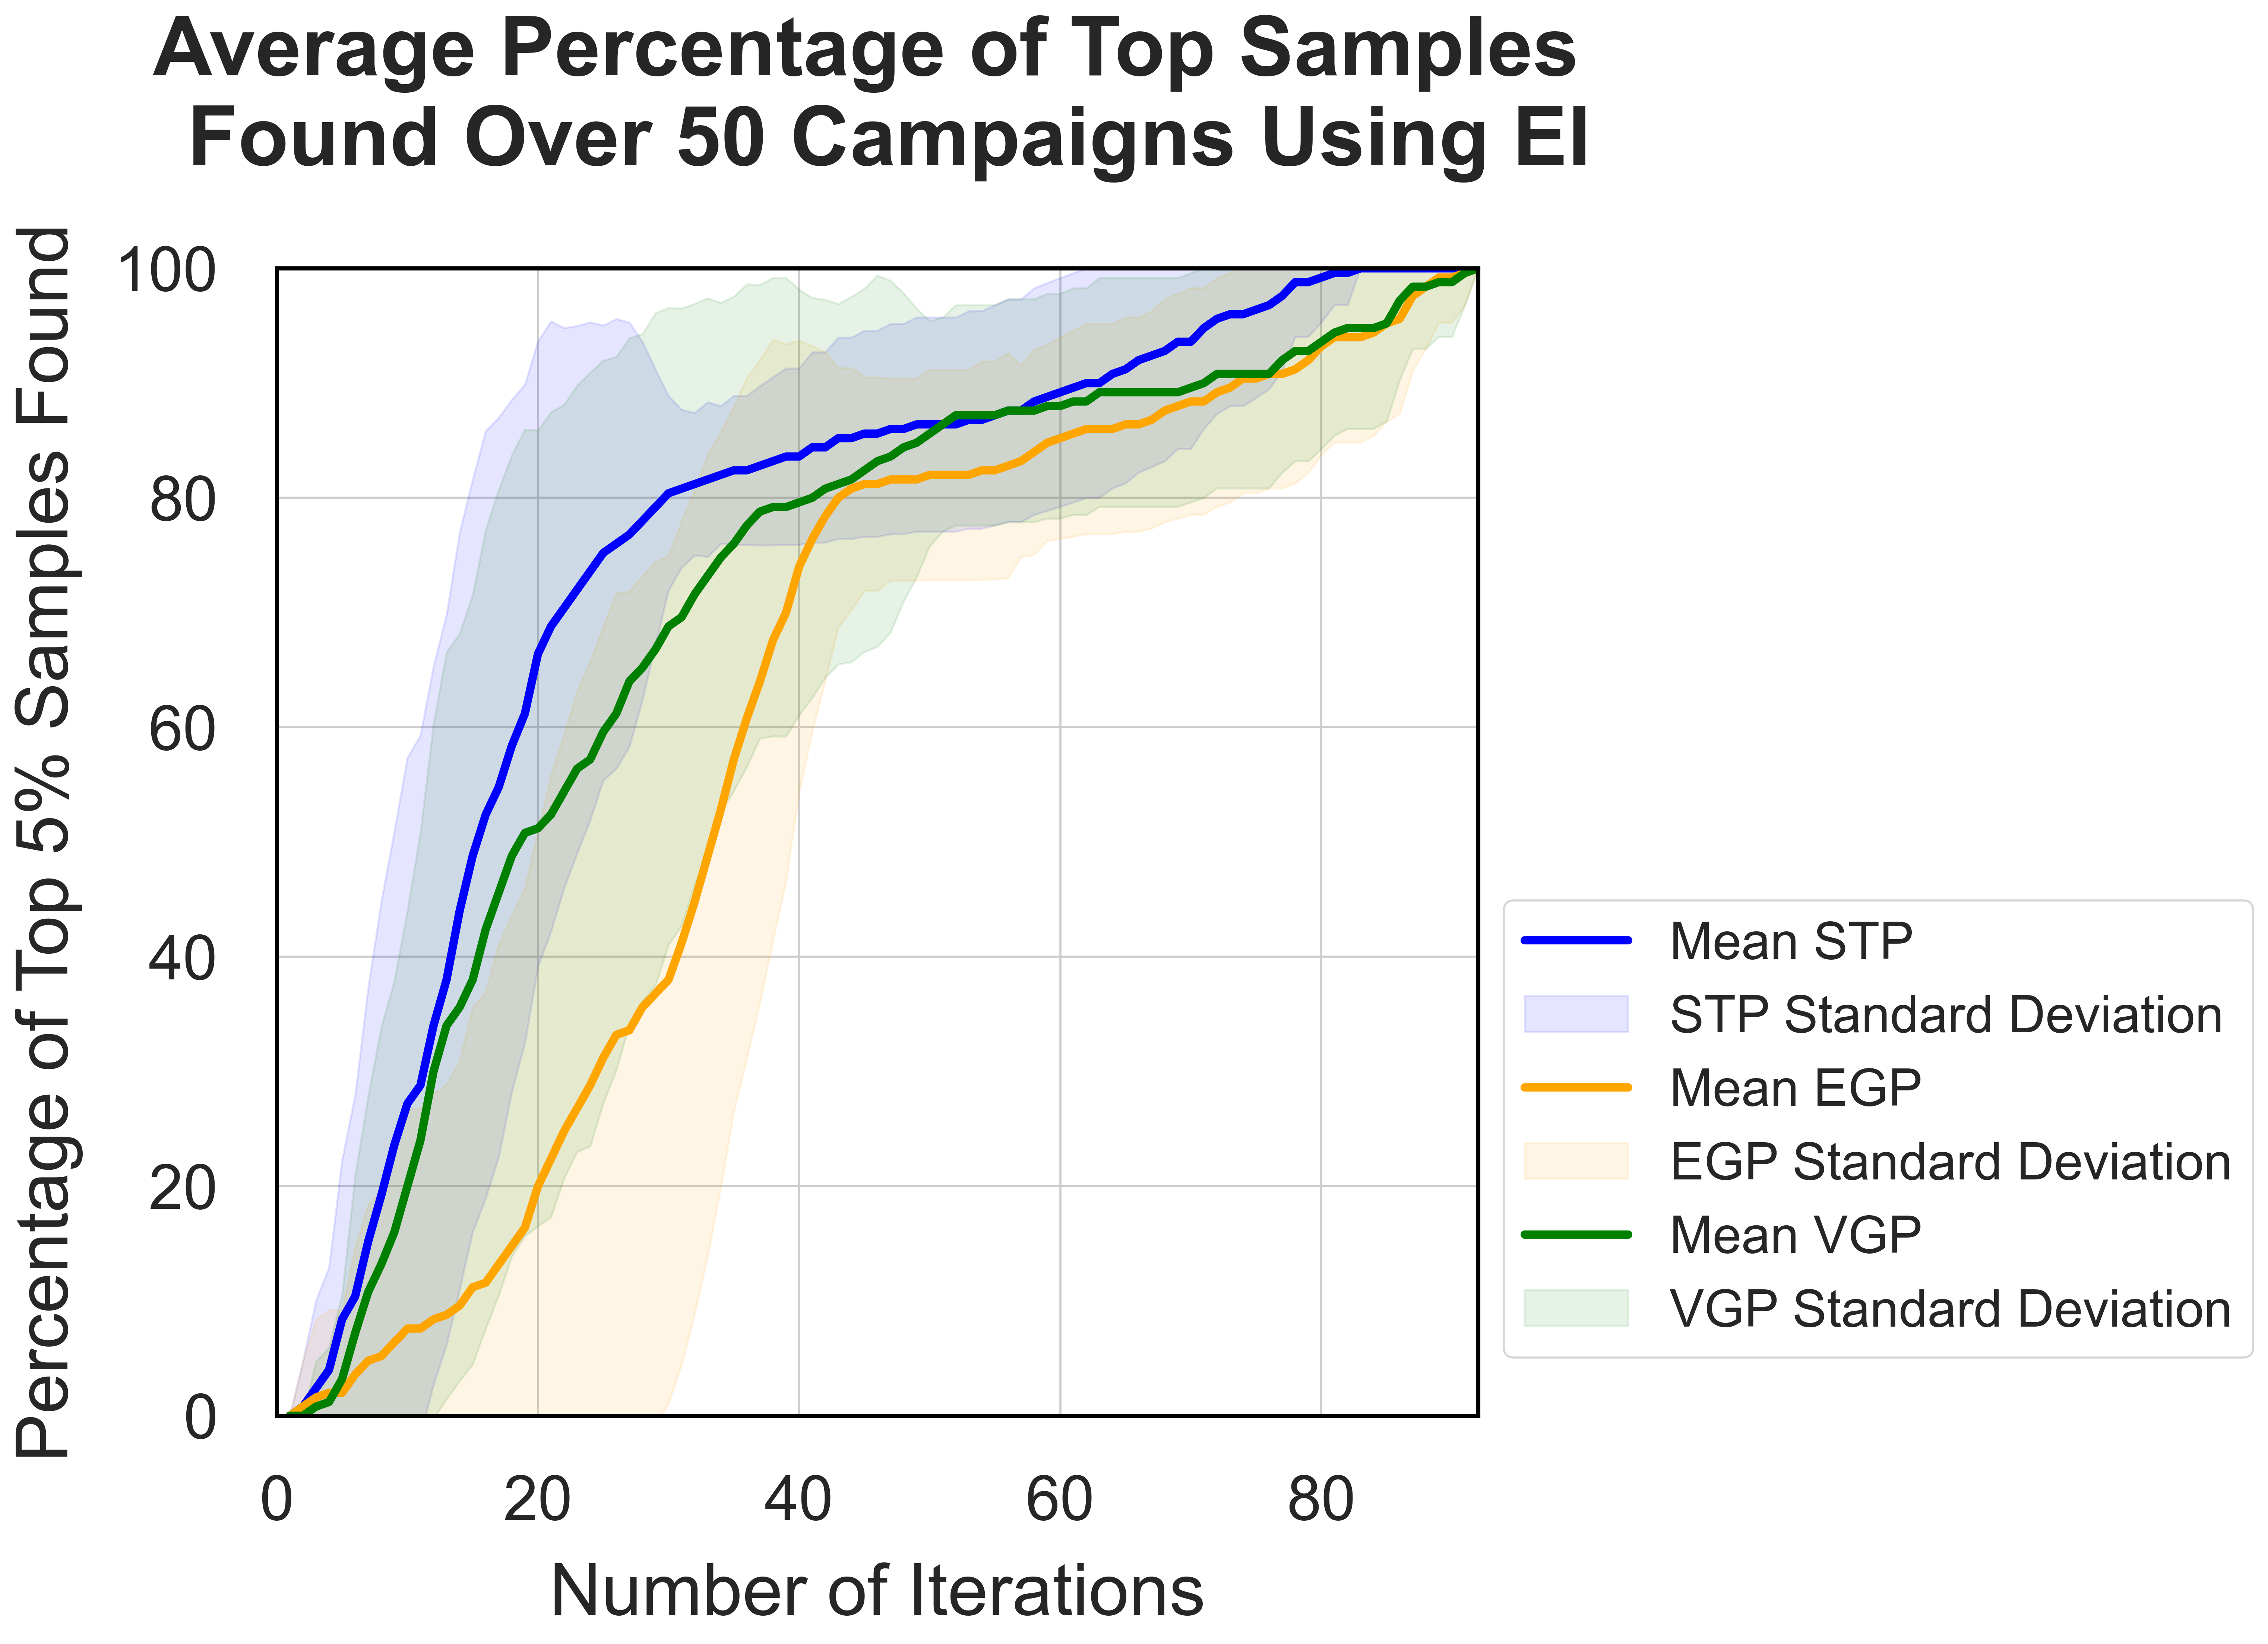

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [100]:
noises = [0.015]
for i in range(len(noises)):
    campaigns = 50
    set_seeds(101)
    acqFunc = "EI"
    noise = noises[i]
    initialPoints = 3
    training_iterations, num_initial_points, num_new_samples_per_iteration, total_samples, acqFunc, noise = setup(initialPoints, acqFunc, noise)
    train_x, train_y, top_samples, true_functionX, true_functionY = generate_data(total_samples, noise)
    
    # Generate a list of seeds randomly picked from the range 0-1000 equal to the number of campaigns without repeating
    seedList = random.sample(range(1000), campaigns)

    for i in trange(len(seedList)):
        globals()['topSTP' + str(i)], globals()['iterationSTP' + str(i)], globals()['meanSTP' + str(i)], globals()['stdSTP' + str(i)], globals()['train_xSTP' + str(i)], globals()['train_ySTP' + str(i)]  = runMaxSTP(seedList[i], num_initial_points, acqFunc)


    for i in trange(len(seedList)):
        globals()['topVGP' + str(i)], globals()['iterationVGP' + str(i)], globals()['meanVGP' + str(i)], globals()['stdVGP' + str(i)], globals()['initialPoints' + str(i)], globals()['train_xVGP' + str(i)], globals()['train_yVGP' + str(i)], globals()['initialPointsy' + str(i)] = runMaxVGP(seedList[i], num_initial_points, acqFunc)

    for i in trange(len(seedList)):
        globals()['topEGP' + str(i)], globals()['iterationEGP' + str(i)], globals()['meanEGP' + str(i)], globals()['stdEGP' + str(i)], globals()['train_xEGP' + str(i)], globals()['train_yEGP' + str(i)] = runMaxEGP(seedList[i], num_initial_points, acqFunc)





    num_arrays = len(seedList)  
    # Function to dynamically collect arrays
    def collect_arrays(prefix, num_arrays):
        arrays = []
        for i in range(num_arrays):
            array = globals().get(f'{prefix}{i}', None)
            if array is not None:
                arrays.append(array)
        return arrays

    # Function to pad arrays with the last element to match the maximum length
    def pad_array(array, max_length):
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=array[-1])

    def find_max_length(prefix, num_arrays):
        arrays = collect_arrays(prefix, num_arrays)
        return max(len(arr) for arr in arrays)

    # Process arrays for each type
    def process_arrays(prefix, num_arrays, max_length):
        arrays = collect_arrays(prefix, num_arrays)
        padded_arrays = [pad_array(arr, max_length) for arr in arrays]
        stack = np.stack(padded_arrays)
        mean_values = np.mean(stack, axis=0)
        std_values = np.std(stack, axis=0)
        return mean_values, std_values

    # Process arrays for STP, EGP, and VGP
    max_length_STP = find_max_length('topSTP', num_arrays)
    max_length_EGP = find_max_length('topEGP', num_arrays)
    max_length_VGP = find_max_length('topVGP', num_arrays)
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    mean_topSTP, std_valuesSTP = process_arrays('topSTP', num_arrays, max_length)
    mean_topEGP, std_valuesEGP = process_arrays('topEGP', num_arrays, max_length)
    mean_topVGP, std_valuesVGP = process_arrays('topVGP', num_arrays, max_length)

    # Ensure that the number of iterations matches the longest array length
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    iterations = np.arange(1, max_length + 1)

    sns.set(style="whitegrid")
    # Plot the mean and fill between the min and max for each type
    fig = plt.figure(figsize=(13, 10), dpi=400)
    ax = plt.subplot(111)

    # Plot for STP
    ax.plot(iterations, mean_topSTP, label='Mean STP', color='blue', linewidth=4)
    ax.fill_between(iterations, mean_topSTP - std_valuesSTP, mean_topSTP + std_valuesSTP, label='STP Standard Deviation', color='blue', alpha=0.1)

    # Plot for EGP
    ax.plot(iterations, mean_topEGP, label='Mean EGP', color='orange', linewidth=4)
    ax.fill_between(iterations, mean_topEGP - std_valuesEGP, mean_topEGP + std_valuesEGP, label='EGP Standard Deviation', color='orange', alpha=0.1)   

    # Plot for VGP
    ax.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=4)
    ax.fill_between(iterations, mean_topVGP - std_valuesVGP, mean_topVGP + std_valuesVGP, label='VGP Standard Deviation', color='green', alpha=0.1)

    plt.xlabel('Number of Iterations', fontsize=35, labelpad=15)
    plt.ylabel('Percentage of Top 5% Samples Found', fontsize=35, labelpad=15)
    # make title bold
    plt.title(f'Average Percentage of Top Samples \n Found Over {num_arrays} Campaigns Using EI', fontsize=40, pad=50, fontweight='bold')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=25)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # set border color
        spine.set_linewidth(2)   
        

    # Customize ticks
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    # extend the tick marks outward
    ax.tick_params(direction='out', length=25)  # adjust length as needed     # set border width

    # Adjust axis limits and aspect ratio if needed
    plt.ylim(0, 100)
    plt.xlim(0, max_length)

    # save the plot 
    plt.savefig(f'2DEI{campaigns}Campaigns{noise}NoiseMax.png')
    plt.show()

    # assuming the necessary data is already defined
    x_min = min(train_x.min().item(), train_xSTP1.min().item(), train_xEGP1.min().item(), train_xVGP1.min().item())
    x_max = max(train_x.max().item(), train_xSTP1.max().item(), train_xEGP1.max().item(), train_xVGP1.max().item())

    # calculate the RMSE for each model using the true function and the mean
    rmseSTP = math.sqrt(mean_squared_error(true_functionY, meanSTP1.numpy()))
    rmseEGP = math.sqrt(mean_squared_error(true_functionY, meanEGP1.numpy()))
    rmseVGP = math.sqrt(mean_squared_error(true_functionY, meanVGP1.detach().numpy()))

    print(f"RMSE for Student-T Process: {rmseSTP}")
    print(f"RMSE for Exact Gaussian Process: {rmseEGP}")    
    print(f"RMSE for Variational Gaussian Process: {rmseVGP}")

    # First subplot - Student-T Process
    fig = plt.figure(figsize=(16, 8), dpi=400)
    ax = plt.subplot(111)
    ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
    ax.scatter(train_x.numpy(), train_y.numpy(), c='k', label="Data", s=50)
    ax.scatter(train_xSTP1.numpy(), train_ySTP1.numpy(), c='red', label="Observed Points", s=50)
    ax.scatter(initialPoints1, initialPointsy1, c='cyan', label="Initial Points", s=50)
    ax.fill_between(train_x.numpy(), (meanSTP1 - 2*stdSTP1).numpy(), (meanSTP1 + 2*stdSTP1).numpy(), color='grey', alpha=0.5, label='Uncertainty (lik-t GP)')
    ax.plot(train_x.numpy(), meanSTP1.numpy(), 'b-', label="STP mean", color='blue', lw=2)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # set border color
        spine.set_linewidth(2)  


    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=25)

    ax.set_title(f"Student T Process \n using Expected Improvement", fontsize=40, pad=50, fontweight='bold')
    plt.xlim(x_min, x_max)
    plt.ylim(-2, 2)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    ax.tick_params(direction='out', length=25)  # adjust length as needed
    plt.savefig(f"{acqFunc}2D{noise}Noise{num_initial_points}StartingPointsSTP.png")
    plt.show()

    # Second subplot - Gaussian Process
    fig = plt.figure(figsize=(16, 8), dpi=400)
    ax = plt.subplot(111)
    ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
    ax.scatter(train_x.numpy(), train_y.numpy(), c='k', label="Data", s=50)
    ax.scatter(train_xEGP1.numpy(), train_yEGP1.numpy(), c='red', label="Observed Points", s=50)
    ax.scatter(initialPoints1, initialPointsy1, c='cyan', label="Initial Points", s=50)
    ax.fill_between(train_x.numpy(), (meanEGP1 - 2*stdEGP1).numpy(), (meanEGP1 + 2*stdEGP1).numpy(), color='grey', alpha=0.5, label='Uncertainty (GP)')
    ax.plot(train_x.numpy(), meanEGP1.numpy(), 'b-', label="EGP mean", color='blue', lw=2)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # set border color
        spine.set_linewidth(2)  

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=25)

    ax.set_title(f"Exact Gaussian Process \n using Expected Improvement", fontsize=40, pad=50, fontweight='bold')
    plt.xlim(x_min, x_max)
    plt.ylim(-2, 2)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    ax.tick_params(direction='out', length=25)  # adjust length as needed
    plt.savefig(f"{acqFunc}2D{noise}Noise{num_initial_points}StartingPointsEGP.png")
    plt.show()

    # Third subplot - Variational Gaussian Process
    fig = plt.figure(figsize=(16, 8), dpi=400)
    ax = plt.subplot(111)
    ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
    ax.scatter(train_x.numpy(), train_y.numpy(), c='k', label="Data", s=50)
    ax.scatter(train_xVGP1.numpy(), train_yVGP1.numpy(), c='red', label="Observed Points", s=50)
    ax.scatter(initialPoints1, initialPointsy1, c='cyan', label="Initial Points", s=50)
    ax.fill_between(train_x.numpy(), (meanVGP1 - 2*stdVGP1).detach().numpy(), (meanVGP1 + 2*stdVGP1).detach().numpy(), color='grey', alpha=0.5, label='Uncertainty (VGP)')
    ax.plot(train_x.numpy(), meanVGP1.detach().numpy(), 'b-', label="VGP mean", color='blue', lw=2)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # set border color
        spine.set_linewidth(2)  

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=25)

    ax.set_title(f"Variational Gaussian Process \n using Expected Improvement", fontsize=40, pad=50, fontweight='bold')
    plt.xlim(x_min, x_max)
    plt.ylim(-2, 2)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    ax.tick_params(direction='out', length=25)  # adjust length as needed
    plt.savefig(f"{acqFunc}2D{noise}Noise{num_initial_points}StartingPointsVGP.png")
    plt.show()

    

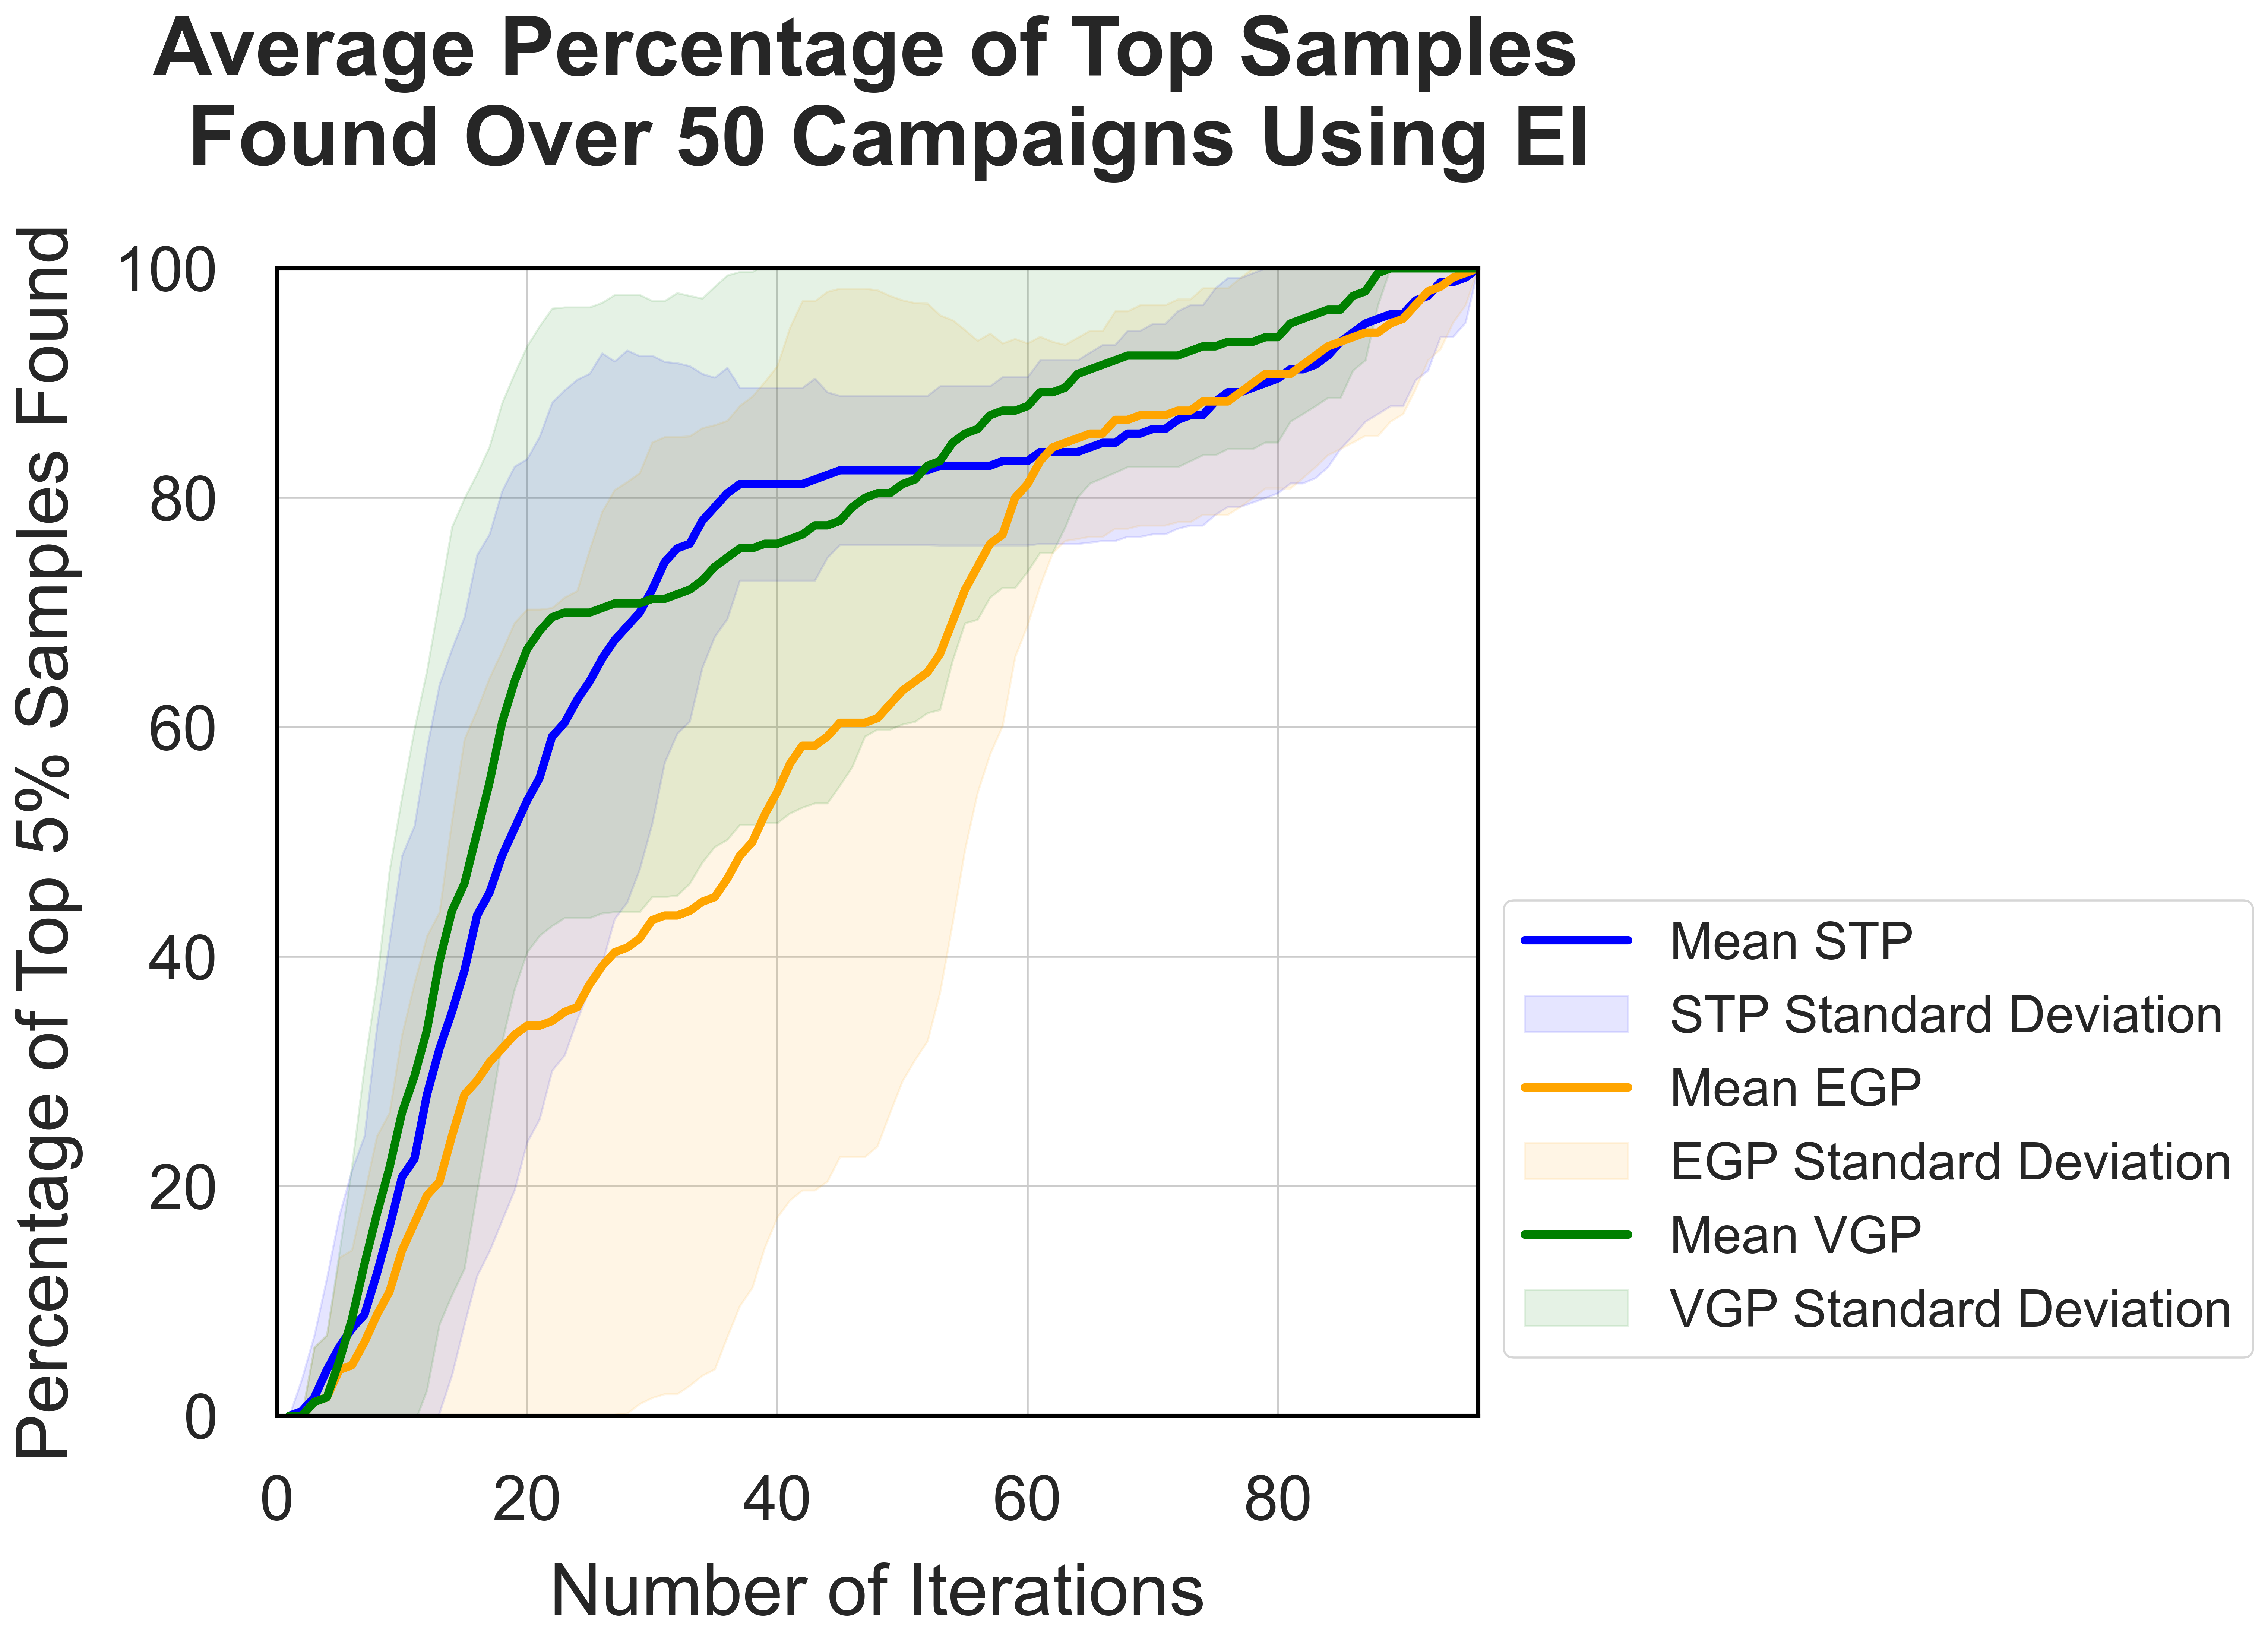

In [ ]:
sns.set(style="whitegrid")
# Plot the mean and fill between the min and max for each type
fig = plt.figure(figsize=(13, 10), dpi=400)
ax = plt.subplot(111)

# Plot for STP
ax.plot(iterations, mean_topSTP, label='Mean STP', color='blue', linewidth=4)
ax.fill_between(iterations, mean_topSTP - std_valuesSTP, mean_topSTP + std_valuesSTP, label='STP Standard Deviation', color='blue', alpha=0.1)

# Plot for EGP
ax.plot(iterations, mean_topEGP, label='Mean EGP', color='orange', linewidth=4)
ax.fill_between(iterations, mean_topEGP - std_valuesEGP, mean_topEGP + std_valuesEGP, label='EGP Standard Deviation', color='orange', alpha=0.1)   

# Plot for VGP
ax.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=4)
ax.fill_between(iterations, mean_topVGP - std_valuesVGP, mean_topVGP + std_valuesVGP, label='VGP Standard Deviation', color='green', alpha=0.1)

plt.xlabel('Number of Iterations', fontsize=35, labelpad=15)
plt.ylabel('Percentage of Top 5% Samples Found', fontsize=35, labelpad=15)
# make title bold
plt.title(f'Average Percentage of Top Samples \n Found Over {num_arrays} Campaigns Using EI', fontsize=40, pad=50, fontweight='bold')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=25)
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # set border color
    spine.set_linewidth(2)   
    

# Customize ticks
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# extend the tick marks outward
ax.tick_params(direction='out', length=25)  # adjust length as needed     # set border width

# Adjust axis limits and aspect ratio if needed
plt.ylim(0, 100)
plt.xlim(0, max_length)

# save the plot 
plt.savefig(f'2DEI{campaigns}Campaigns{noise}NoiseMax.png')
plt.show()

RMSE for Student-T Process: 0.1566188178673094
RMSE for Exact Gaussian Process: 0.44299812444170944
RMSE for Variational Gaussian Process: 0.21660203009068116


C:\Users\stan\AppData\Local\Temp\ipykernel_417684\3926333807.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
C:\Users\stan\AppData\Local\Temp\ipykernel_417684\3926333807.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(train_x.numpy(), meanSTP.numpy(), 'b-', label="STP mean", color='blue', lw=2)


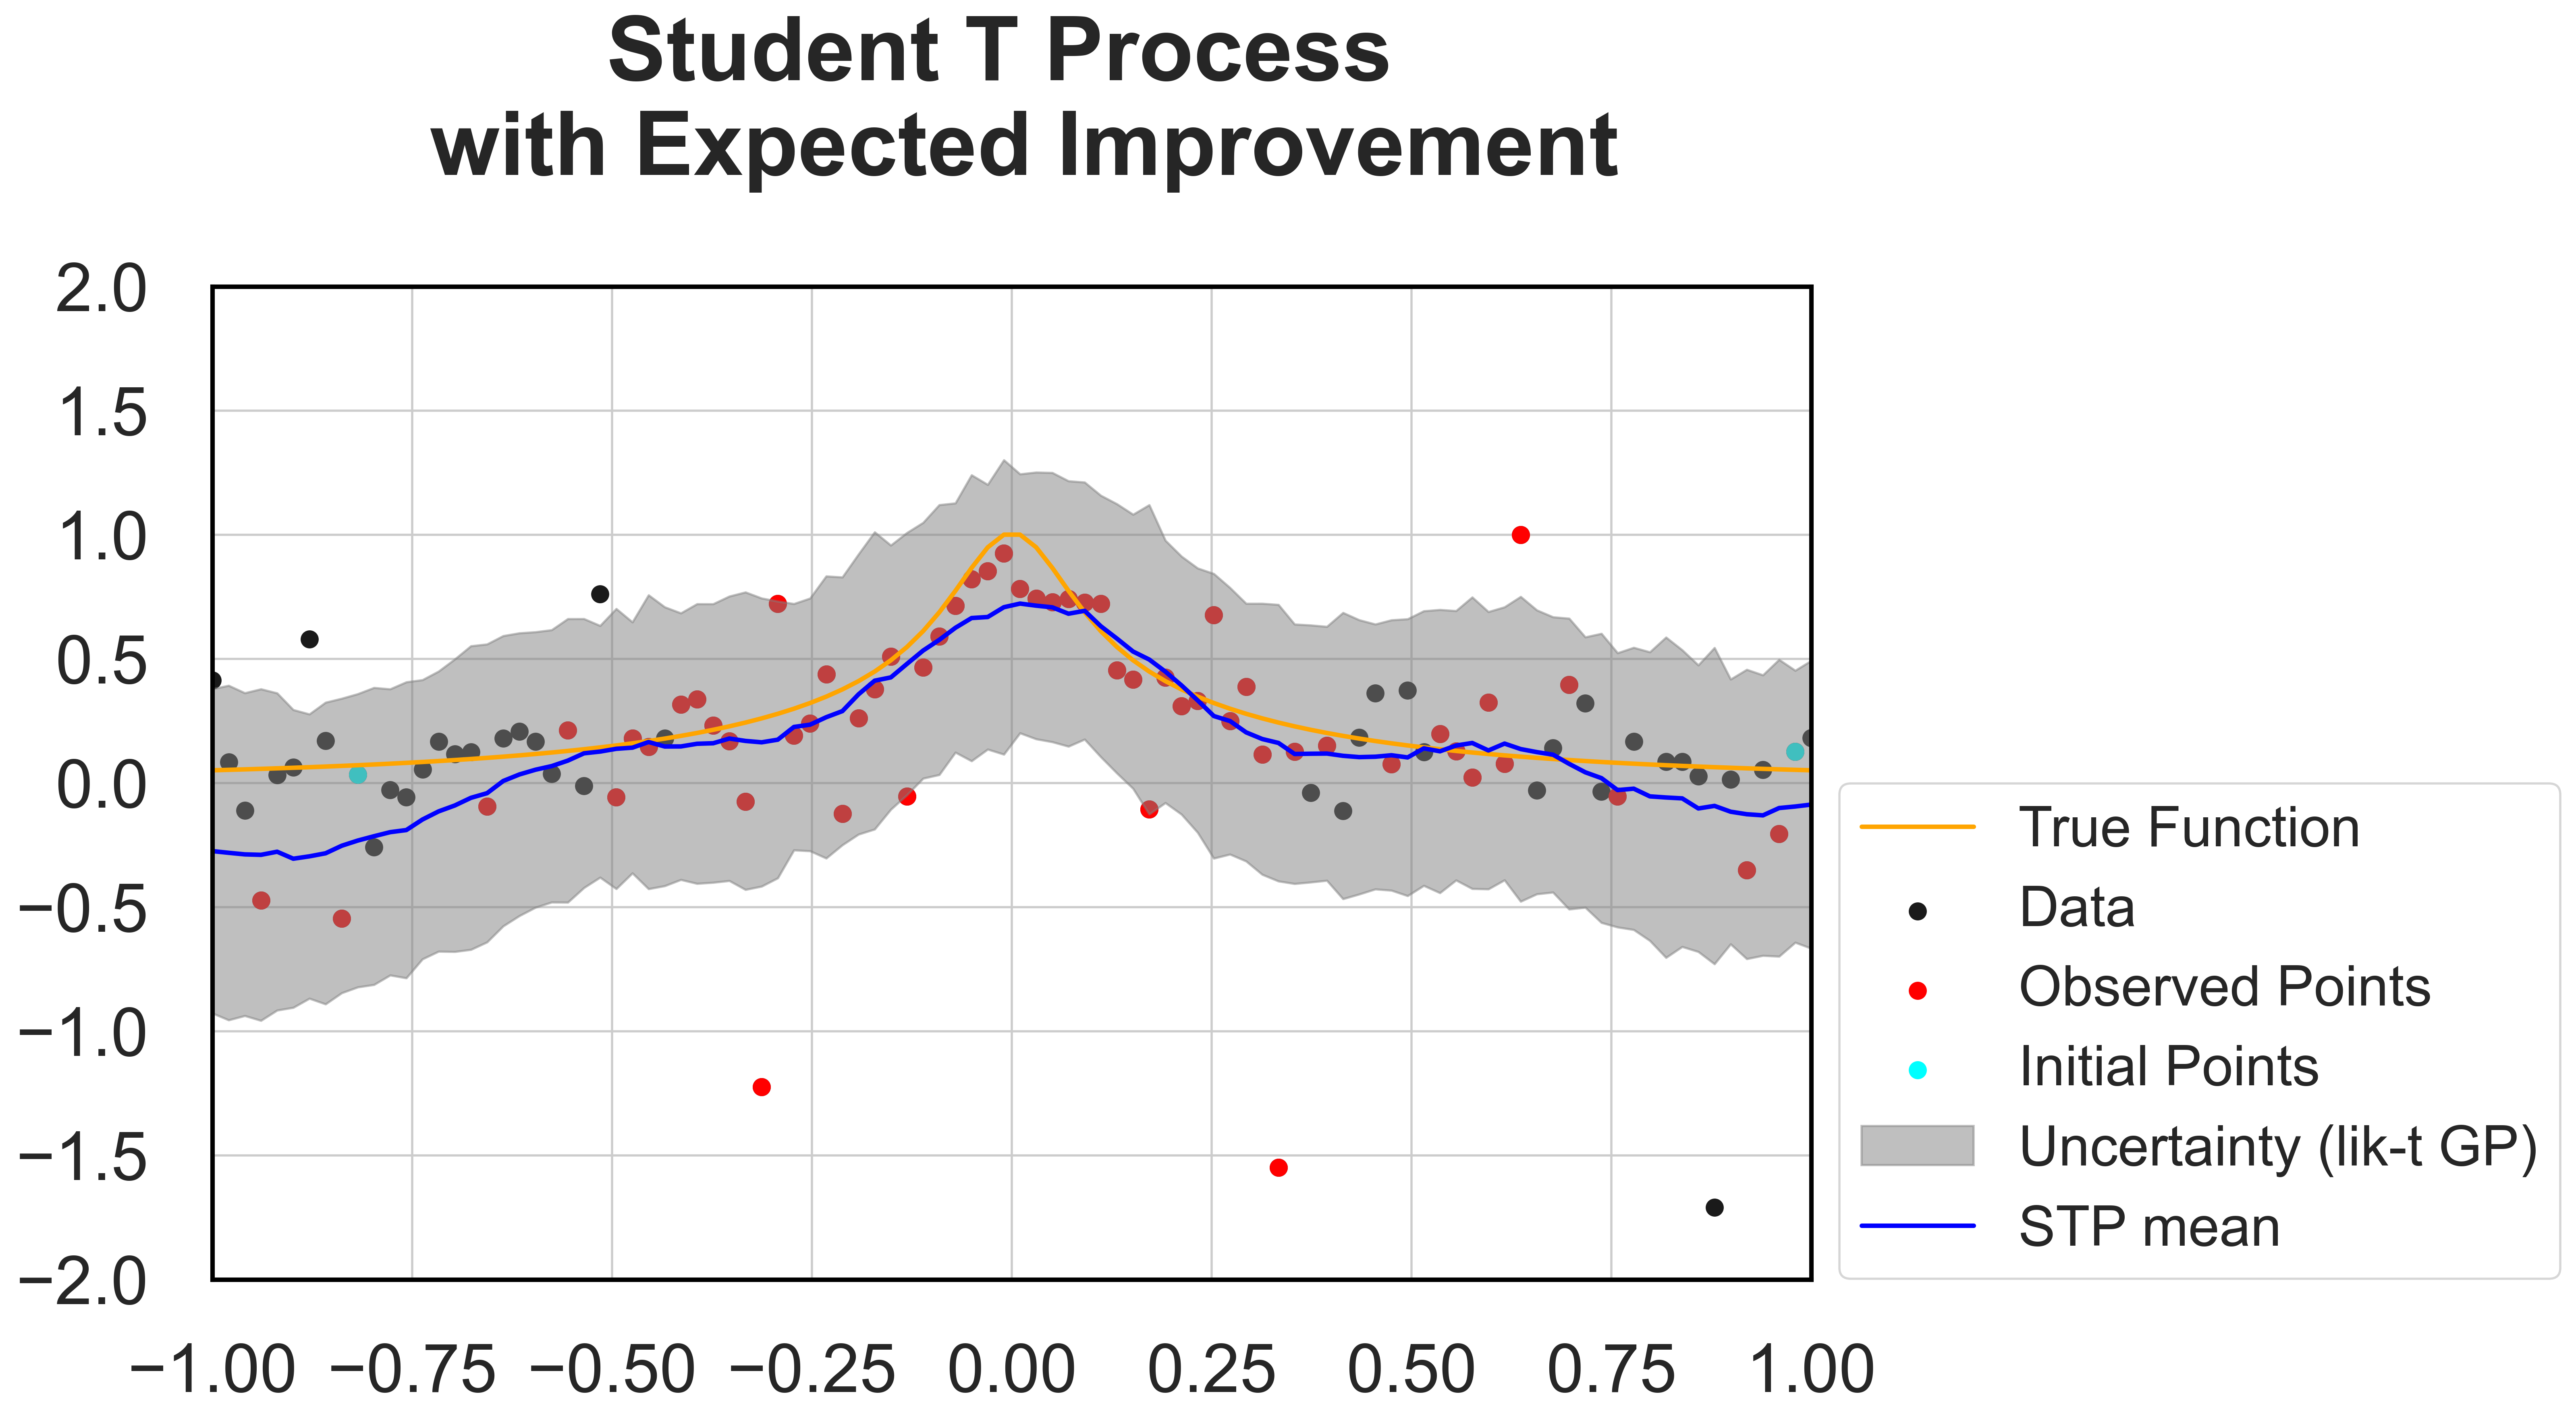

C:\Users\stan\AppData\Local\Temp\ipykernel_417684\3926333807.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
C:\Users\stan\AppData\Local\Temp\ipykernel_417684\3926333807.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(train_x.numpy(), meanEGP.detach().numpy(), 'b-', label="EGP mean", color='blue', lw=2)


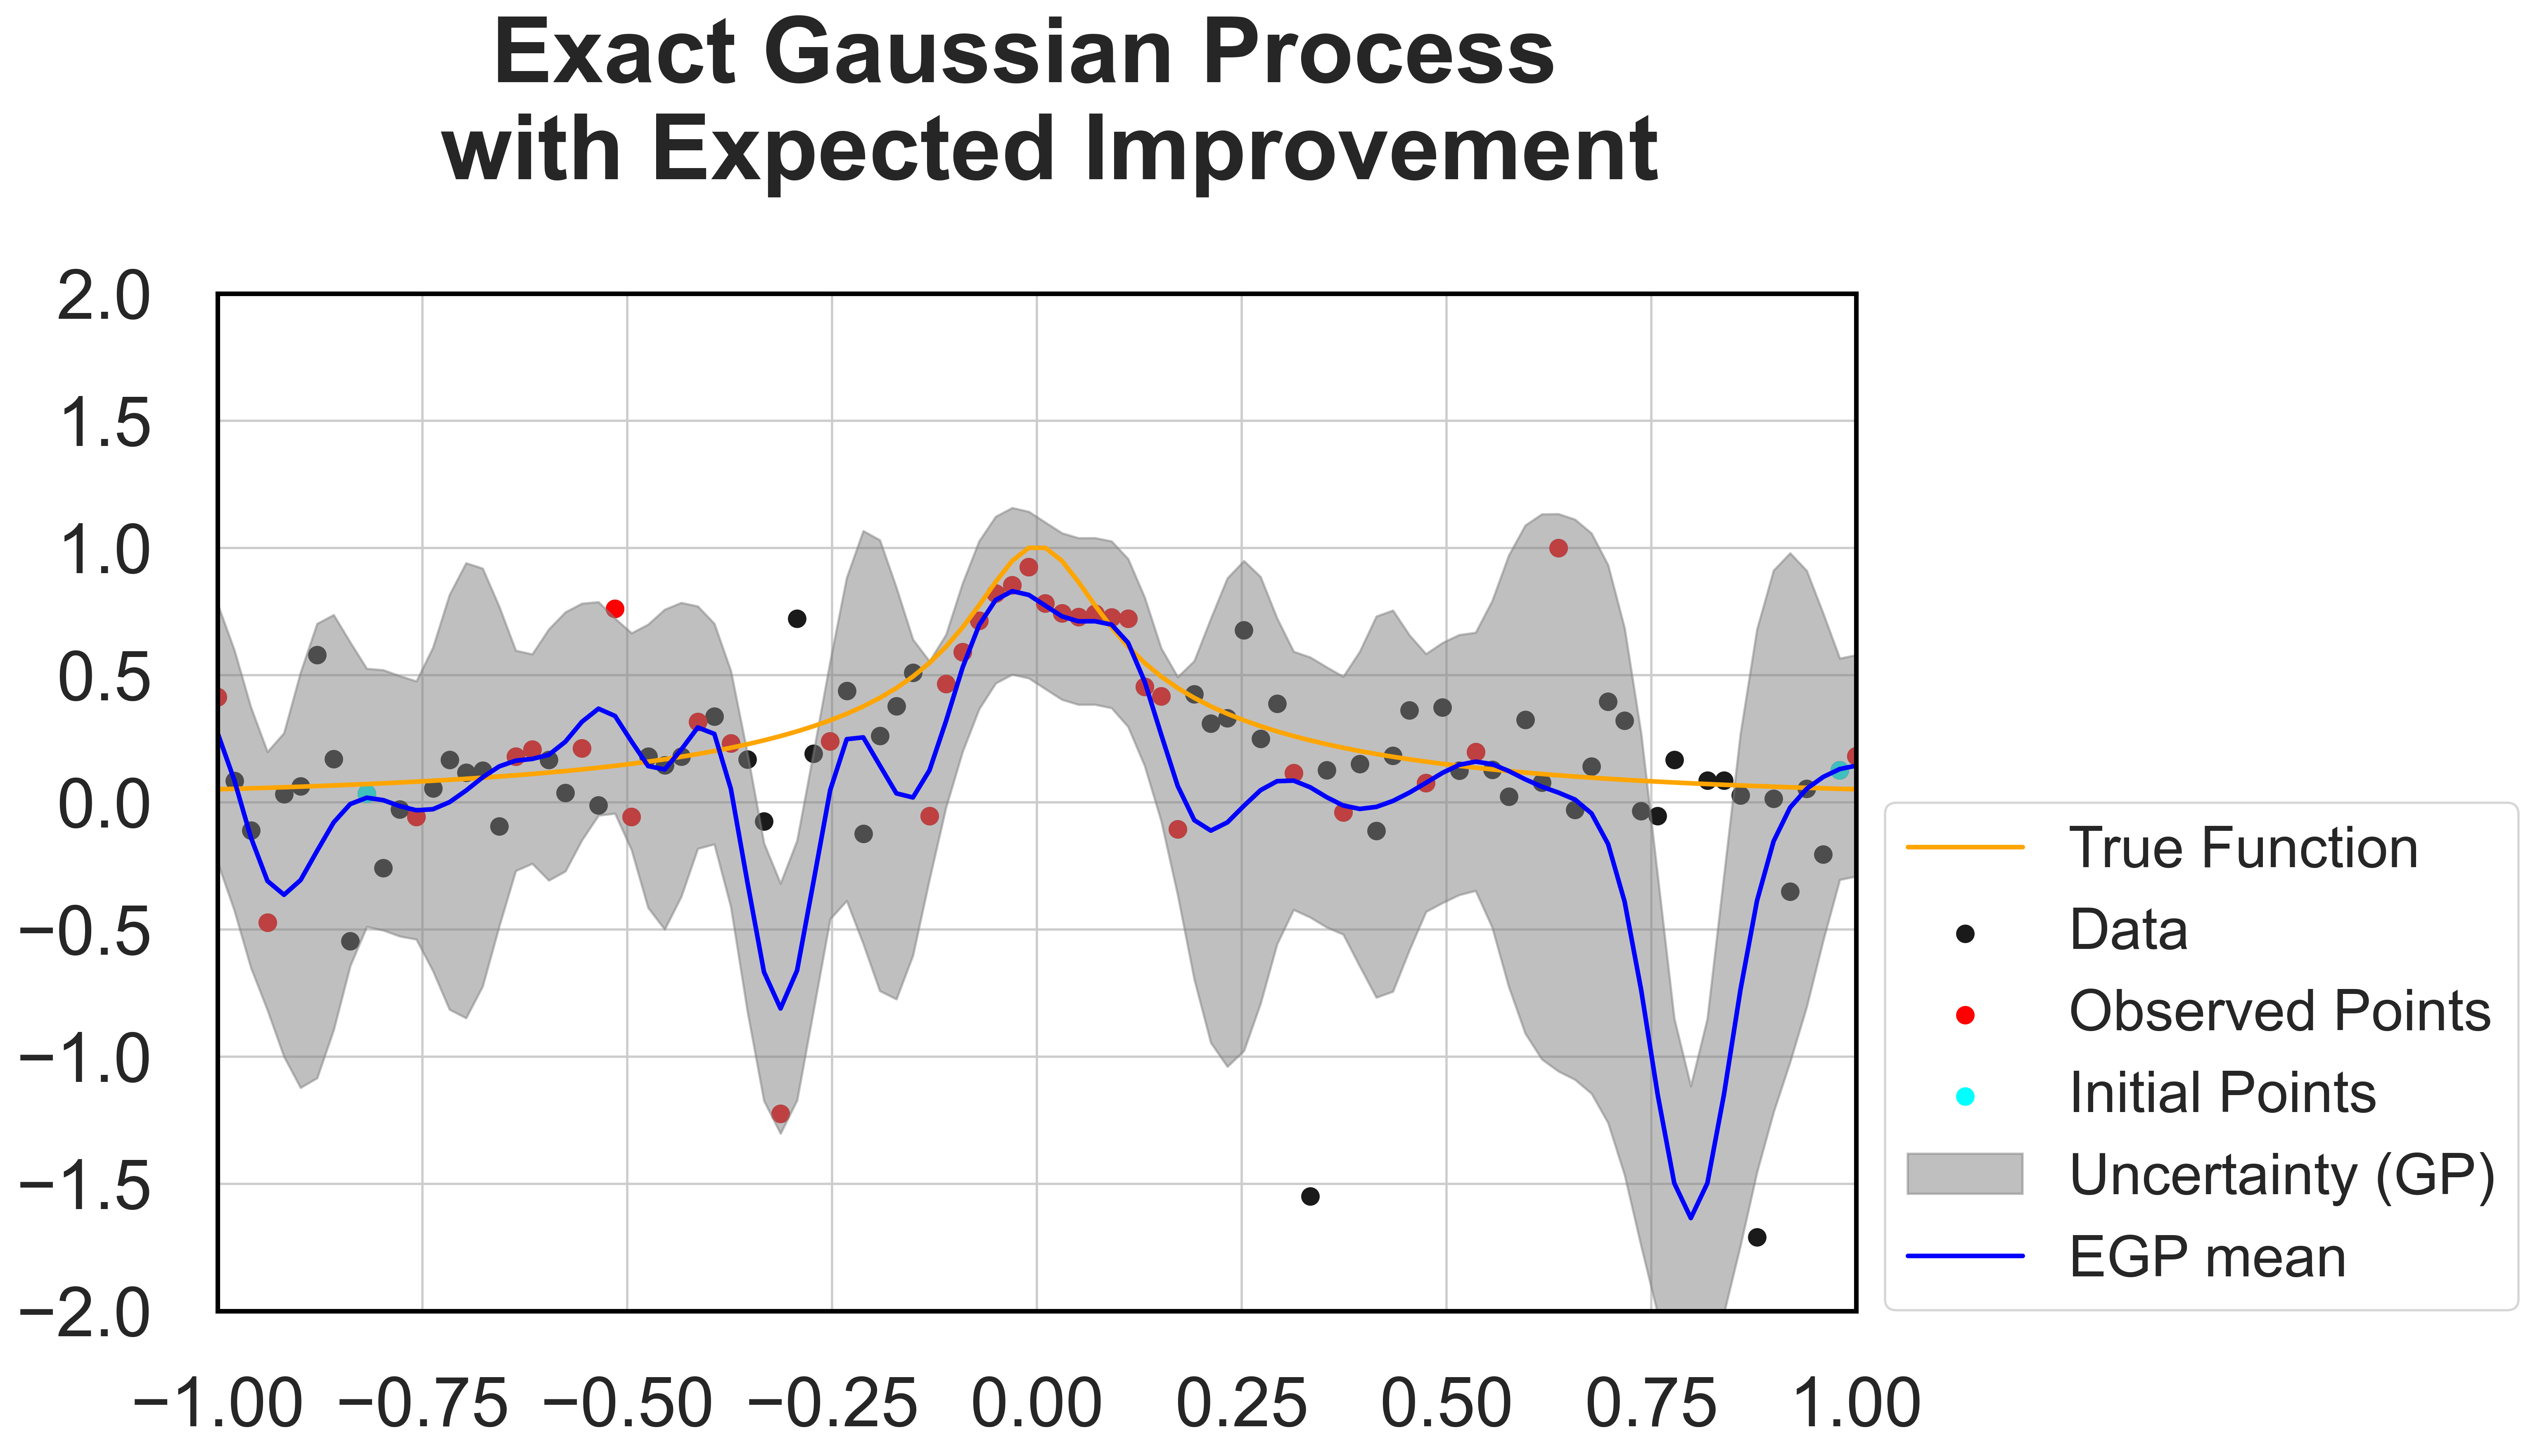

C:\Users\stan\AppData\Local\Temp\ipykernel_417684\3926333807.py:94: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
C:\Users\stan\AppData\Local\Temp\ipykernel_417684\3926333807.py:99: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(train_x.numpy(), meanVGP.detach().numpy(), 'b-', label="VGP mean", color='blue', lw=2)


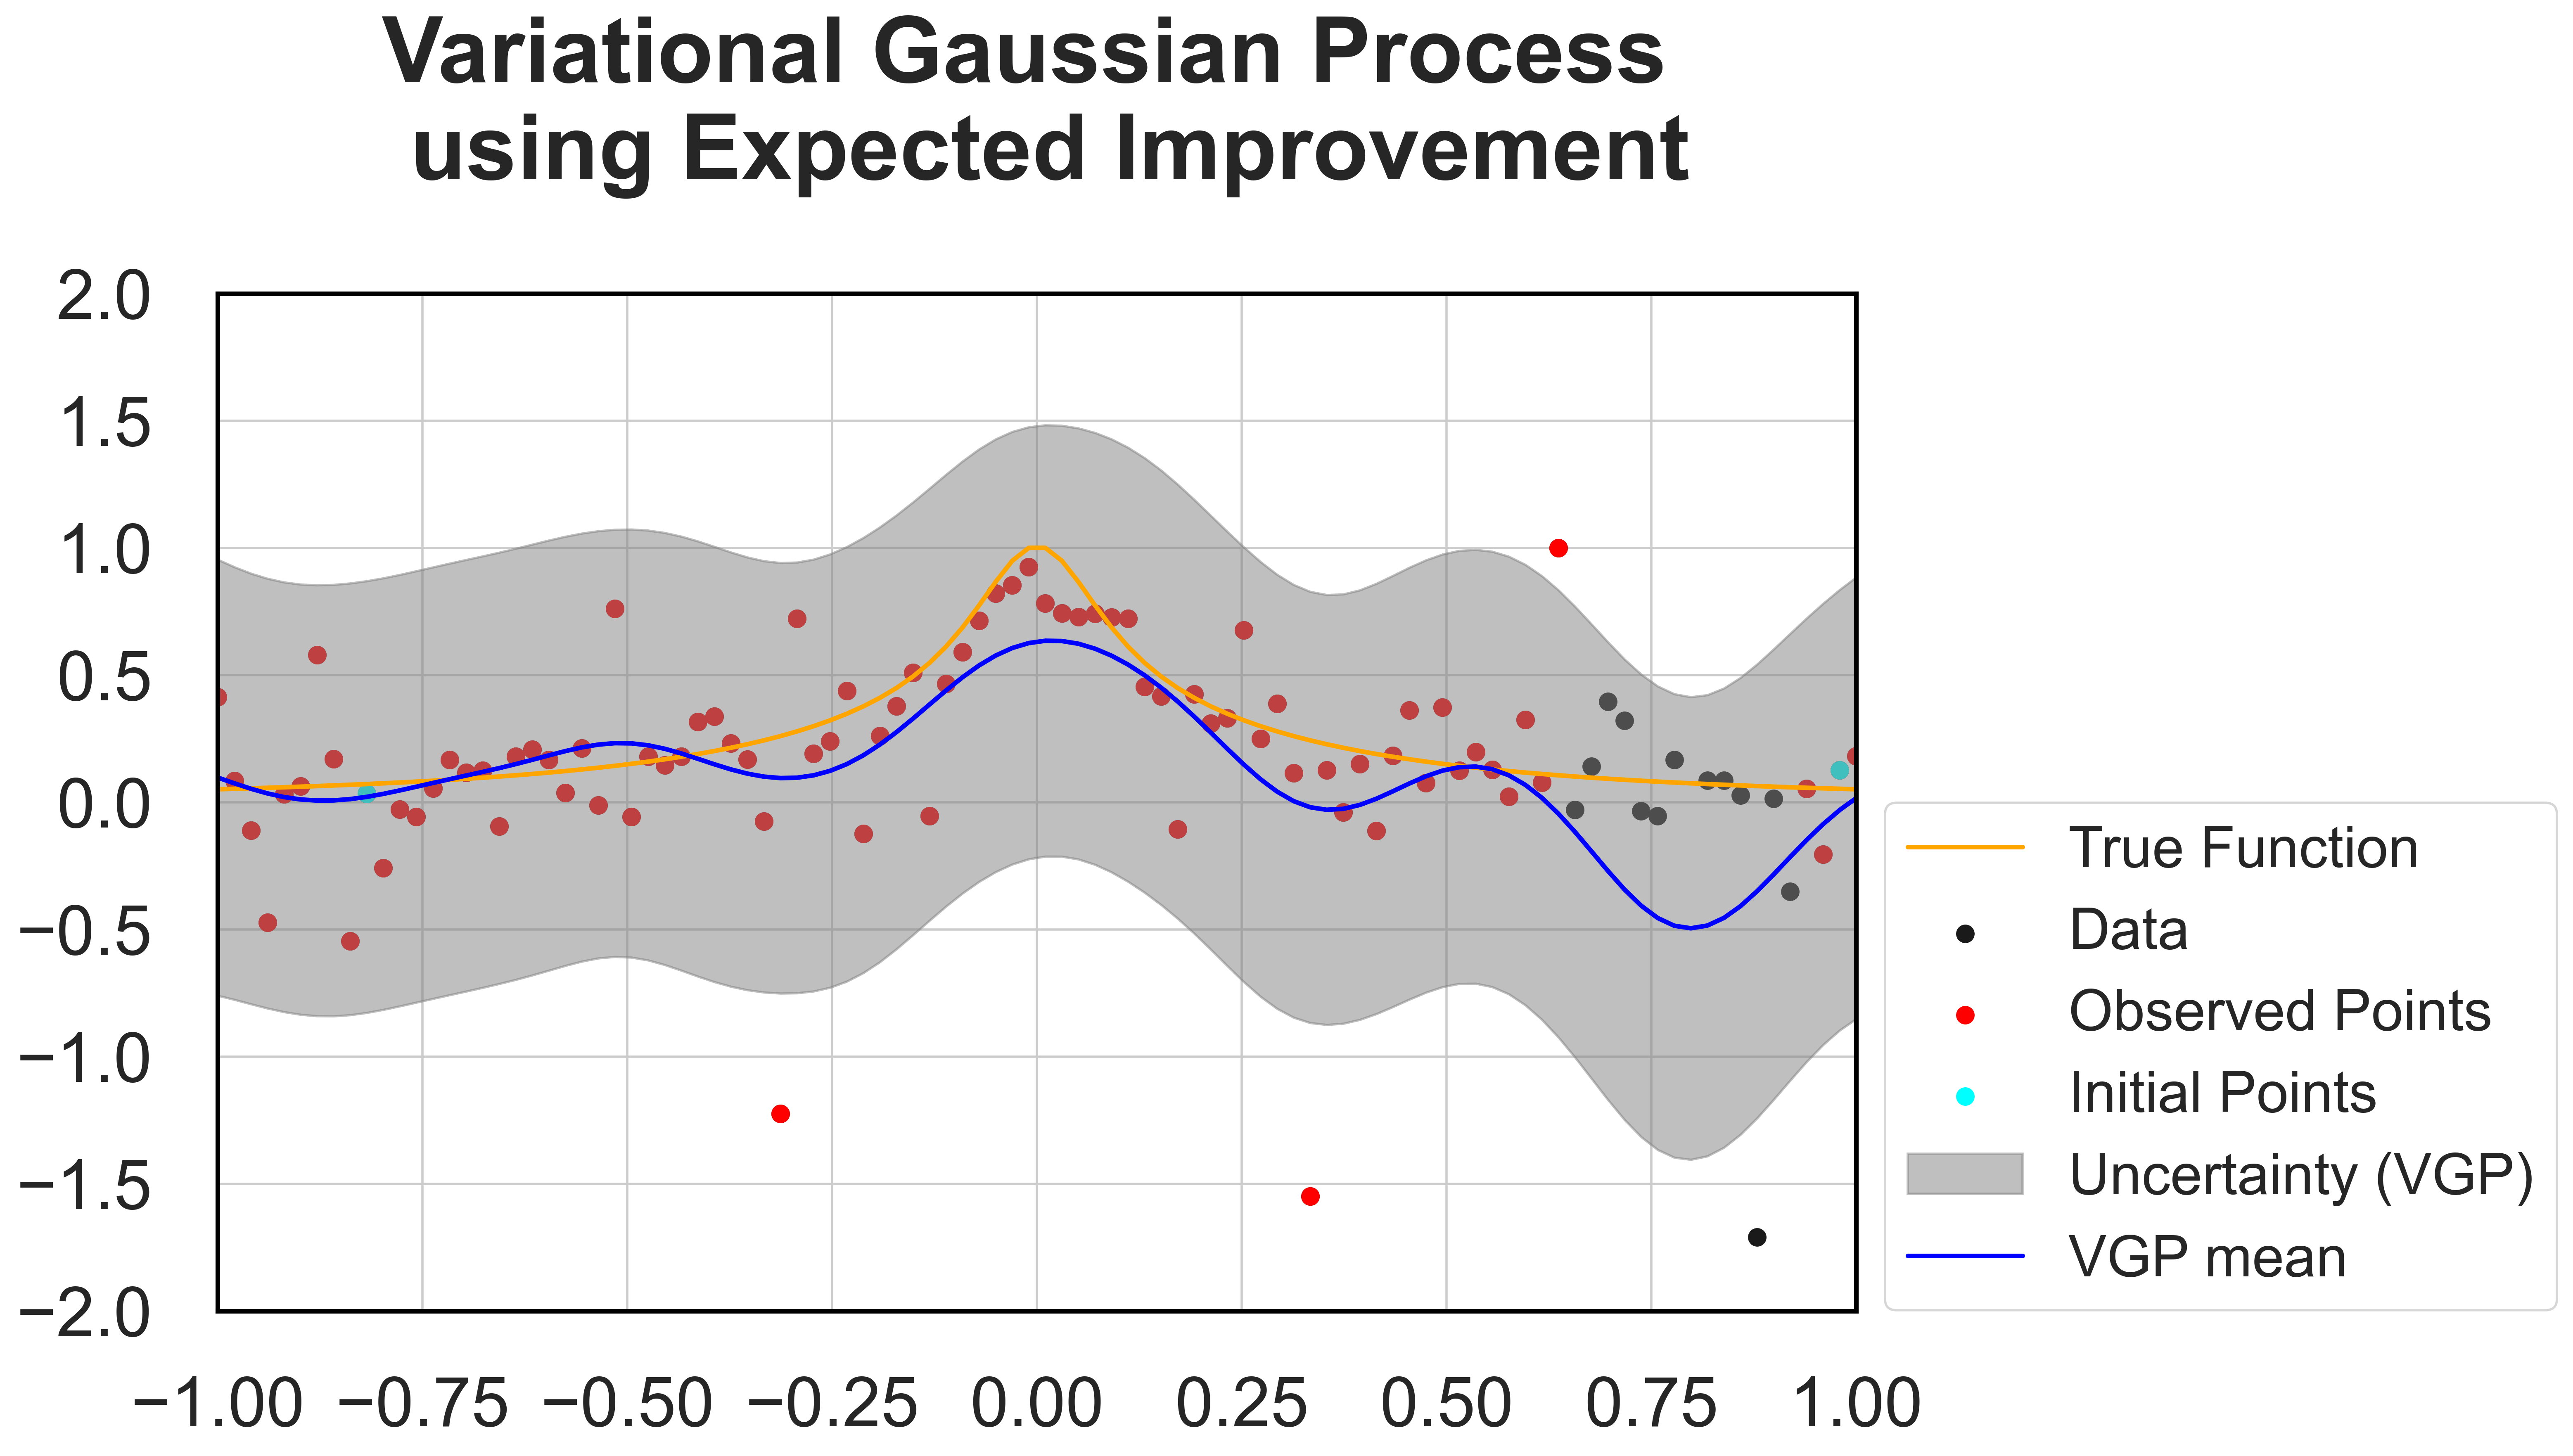

In [102]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# assuming the necessary data is already defined
setNum = 11

# dynamically select the datasets based on setNum
train_xSTP = globals()[f'train_xSTP{setNum}']
train_ySTP = globals()[f'train_ySTP{setNum}']
train_xEGP = globals()[f'train_xEGP{setNum}']
train_yEGP = globals()[f'train_yEGP{setNum}']
train_xVGP = globals()[f'train_xVGP{setNum}']
train_yVGP = globals()[f'train_yVGP{setNum}']

meanSTP = globals()[f'meanSTP{setNum}']
meanEGP = globals()[f'meanEGP{setNum}']
meanVGP = globals()[f'meanVGP{setNum}']

stdSTP = globals()[f'stdSTP{setNum}']
stdEGP = globals()[f'stdEGP{setNum}']
stdVGP = globals()[f'stdVGP{setNum}']

initialPoints = globals()[f'initialPoints{setNum}']
initialPointsy = globals()[f'initialPointsy{setNum}']

x_min = min(train_x.min().item(), train_xSTP.min().item(), train_xEGP.min().item(), train_xVGP.min().item())
x_max = max(train_x.max().item(), train_xSTP.max().item(), train_xEGP.max().item(), train_xVGP.max().item())

# calculate the RMSE for each model using the true function and the mean
rmseSTP = math.sqrt(mean_squared_error(true_functionY, meanSTP.numpy()))
rmseEGP = math.sqrt(mean_squared_error(true_functionY, meanEGP.detach().numpy()))
rmseVGP = math.sqrt(mean_squared_error(true_functionY, meanVGP.detach().numpy()))

print(f"RMSE for Student-T Process: {rmseSTP}")
print(f"RMSE for Exact Gaussian Process: {rmseEGP}")    
print(f"RMSE for Variational Gaussian Process: {rmseVGP}")

# First subplot - Student-T Process
fig = plt.figure(figsize=(16, 8), dpi=400)
ax = plt.subplot(111)
ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
ax.scatter(train_x.numpy(), train_y.numpy(), c='k', label="Data", s=50)
ax.scatter(train_xSTP.numpy(), train_ySTP.numpy(), c='red', label="Observed Points", s=50)
ax.scatter(initialPoints, initialPointsy, c='cyan', label="Initial Points", s=50)
ax.fill_between(train_x.numpy(), (meanSTP - 2*stdSTP).numpy(), (meanSTP + 2*stdSTP).numpy(), color='grey', alpha=0.5, label='Uncertainty (lik-t GP)')
ax.plot(train_x.numpy(), meanSTP.numpy(), 'b-', label="STP mean", color='blue', lw=2)
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # set border color
    spine.set_linewidth(2)  

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=25)

ax.set_title(f"Student T Process \n with Expected Improvement", fontsize=40, pad=50, fontweight='bold')
plt.xlim(x_min, x_max)
plt.ylim(-2, 2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.tick_params(direction='out', length=25)  # adjust length as needed
plt.savefig(f"{acqFunc}2D{noise}Noise{num_initial_points}StartingPointsSTP.png")
plt.show()

# Second subplot - Gaussian Process
fig = plt.figure(figsize=(16, 8), dpi=400)
ax = plt.subplot(111)
ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
ax.scatter(train_x.numpy(), train_y.numpy(), c='k', label="Data", s=50)
ax.scatter(train_xEGP.numpy(), train_yEGP.numpy(), c='red', label="Observed Points", s=50)
ax.scatter(initialPoints, initialPointsy, c='cyan', label="Initial Points", s=50)
ax.fill_between(train_x.numpy(), (meanEGP - 2*stdEGP).detach().numpy(), (meanEGP + 2*stdEGP).detach().numpy(), color='grey', alpha=0.5, label='Uncertainty (GP)')
ax.plot(train_x.numpy(), meanEGP.detach().numpy(), 'b-', label="EGP mean", color='blue', lw=2)
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # set border color
    spine.set_linewidth(2)  

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=25)

ax.set_title(f"Exact Gaussian Process \n with Expected Improvement", fontsize=40, pad=50, fontweight='bold')
plt.xlim(x_min, x_max)
plt.ylim(-2, 2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.tick_params(direction='out', length=25)  # adjust length as needed
plt.savefig(f"{acqFunc}2D{noise}Noise{num_initial_points}StartingPointsEGP.png")
plt.show()

# Third subplot - Variational Gaussian Process
fig = plt.figure(figsize=(16, 8), dpi=400)
ax = plt.subplot(111)
ax.plot(true_functionX, true_functionY, 'g-', label="True Function", color='orange', lw=2)
ax.scatter(train_x.numpy(), train_y.numpy(), c='k', label="Data", s=50)
ax.scatter(train_xVGP.numpy(), train_yVGP.numpy(), c='red', label="Observed Points", s=50)
ax.scatter(initialPoints, initialPointsy, c='cyan', label="Initial Points", s=50)
ax.fill_between(train_x.numpy(), (meanVGP - 2*stdVGP).detach().numpy(), (meanVGP + 2*stdVGP).detach().numpy(), color='grey', alpha=0.5, label='Uncertainty (VGP)')
ax.plot(train_x.numpy(), meanVGP.detach().numpy(), 'b-', label="VGP mean", color='blue', lw=2)
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # set border color
    spine.set_linewidth(2)  

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=25)

ax.set_title(f"Variational Gaussian Process \n using Expected Improvement", fontsize=40, pad=50, fontweight='bold')
plt.xlim(x_min, x_max)
plt.ylim(-2, 2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.tick_params(direction='out', length=25)  # adjust length as needed
plt.savefig(f"{acqFunc}2D{noise}Noise{num_initial_points}StartingPointsVGP.png")
plt.show()
